# **Étude du papier de recherche**
## *A Unified Framework for U-Net Design and Analysis*

Ce notebook s’inscrit dans le cadre du projet du cours *Generative Models & Simulation* (Master MS2A, Sorbonne Université). Il a pour objectif d’étudier de manière rigoureuse l’article **“A Unified Framework for U-Net Design and Analysis”**, qui propose un cadre mathématique unifié pour la définition, l’analyse et la comparaison des architectures de type U-Net.

Conformément aux consignes du projet, ce travail poursuit les objectifs suivants :

- **Présenter le contexte de l’article**, en explicitant le problème étudié, les types de données considérés, les limites des approches existantes et les apports théoriques et méthodologiques du papier, dans un cadre mathématiquement rigoureux.
- **Décrire clairement la méthode proposée par les auteurs**, en mettant en évidence les idées structurantes du formalisme unifié et les mécanismes clés des architectures U-Net.
- **Adopter une approche algorithmique**, en implémentant une version simplifiée mais fidèle du cadre proposé, afin d’en étudier le comportement et les propriétés sur des données contrôlées.
- **Valider expérimentalement la méthode**, d’abord sur des **données synthétiques** soigneusement construites pour isoler les effets des différentes briques architecturales, puis sur des **données réelles**, afin d’illustrer la pertinence du cadre dans un contexte plus applicatif.
- **Discuter rigoureusement les performances**, en analysant l’impact des choix d’implémentation et des hyperparamètres à la lumière des résultats théoriques présentés dans l’article.

Le notebook est structuré de manière progressive : après la présentation du contexte et du cadre théorique, les concepts sont traduits en une implémentation concrète, puis analysés expérimentalement à travers plusieurs expériences ciblées.

**Auteurs :** Pierre Fontbonne & Erwan Ouabdesselam

In [17]:
# Imports
import os

import torch
import matplotlib.pyplot as plt

from src.data.signal_1d import Signal1DConfig, Signal1DDataModule
from src.analysis import (
    plot_train_val_per_model,
    plot_val_loss_overlay,
    load_best_models,
    make_fixed_batch,
    plot_reconstructions,
    eval_models_table,
    plot_metric_lines
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **1. Contexte et problématique de l’article**

![Illustration issue de DataScienceToday, d’après Ronneberger et al., *U-Net: Convolutional Networks for Biomedical Image Segmentation*, MICCAI 2015.](../figures/unet_diagram.png)

*Figure 1 — Architecture U-Net classique pour la segmentation d’images.*

### **1.1. Pourquoi s’intéresser aux architectures U-Net ?**

Les U-Nets sont devenus des architectures standards dès que l’entrée et la sortie partagent une structure spatiale comparable (segmentation, reconstruction, débruitage, modèles génératifs). Malgré cet usage massif, leur compréhension reste souvent empirique.

L’article cherche à répondre à une question structurante : **comment définir un U-Net de manière suffisamment abstraite**, indépendamment d’un choix particulier de convolutions, de pooling ou de dimensions, afin d’en analyser rigoureusement les propriétés ?

L’objectif est de disposer d’un langage commun permettant :
- de comparer des variantes sur une base cohérente ;
- d’analyser le comportement lorsque la résolution augmente (raffinement des échelles) ;
- et de relier les choix multi-échelles à des phénomènes mesurables (stabilité, transfert d’information entre fréquences, interprétation résiduelle).

Le formalisme proposé est volontairement général : les données sont vues comme des fonctions sur un domaine $X$ juste muni d'une structure de Hilbert pour pouvoir parler de bases et projections. Cette généralité vise notamment des tâches où l’on apprend des opérateurs (reconstruction, débruitage, approximation d’opérateurs liés à des PDE) et des architectures U-Net utilisées dans les modèles de diffusion.

Avant ce travail, la littérature propose surtout des analyses partielles : certaines portent sur des variantes spécifiques, d’autres restent au niveau architectural sans isoler clairement les mécanismes responsables des performances.

Le papier contribut trois résultats structurants.

1. **Définition unifiée des U-Nets.** Les auteurs formalisent l’architecture en termes d’opérateurs multi-échelles, ce qui clarifie la logique “descente–montée” visible dans la figure 1. et permet d’analyser le comportement lorsque la résolution se raffine.

2. **Multi-ResNets.** Ils introduisent une classe d’architectures où l’encodeur est associé à une décomposition multi-résolution (ondelettes orthogonales). Cela permet de séparer ce qui relève de la représentation (fixée) et ce qui relève de l’apprentissage (porté par les parties apprises), et d’injecter des structures a priori.

3. **Analyse fréquentielle (diffusion, base de Haar).** Ils montrent que, dans ce cadre, les composantes haute fréquence deviennent dominées par le bruit plus tôt que les basses fréquences, ce qui donne une justification théorique à certains choix multi-échelles (notamment des opérateurs de type low-pass/average pooling) dans les U-Nets utilisés en diffusion.

## 2. Intuition pour la définition des UNet

_**Voir l'annexe en bas de notebook pour l'approximation multirésolution (MRA)**_

Comme nous l'avons dit, "Unified UNets" propose volontairement un formalisme très général. Au point qu'il puisse être assez difficile de se convaincre de l'interprétation. Nous avons donc mener un travail important pour essayer de bien définir un problème et un ensemble d'hypothèses faisant assez naturellement de la structure de UNet un choix cohérent. Tandis que la section suivante donne la définition d'unet proposée par les auteurs de l'article on va essayer dans donner une intuition naturelle.

Considérons $(x, y) \in L^2 \times L^2$ ou $L^2$ est le Hilbert $L^2(\R^d)$ (ou éventuellement $L^2([0, 1]^d)$) et intéressons nous au problème de régression

$$min_{\theta} \mathbb{E} \left[ l(f_\theta(x), y) \tag{P1} \right]$$

pour une fonction de perte $l$ donnée et une famille paramétrique $\set{f_\theta}$.

Faisons alors l'hypothèse de modélisation de l'extistence et la connaissance d'une **approximation multirésolution (MRA)** $V_0 \subset V_1 \subset \dots \subset L^2$ [[c.f. Annexe]](#annexe) dans lequel le problème $(P1)$ se décompose "bien", c'est à dire que la convergence suivante est "très rapide" : 

$$\mathbb{E} \vert\vert f_\theta(P_{V_j} x) - y \vert\vert^2 \to 0$$

_Remarquons que le résultat, différent, $\mathbb{E} \vert\vert P_{V_j} y - y \vert\vert^2 \to 0$ est bien connu, il dépend de la loi de $y$ et de sa régularité mais est assez facilement accessible._

_Un modèle concret que l'on peut imaginer est celui de la reconstruction de $y$, en prenant $x = y + \epsilon$ où $\epsilon$ est un bruit gaussien et $l$ la perte quadratique c'est un modèle BBG [[c.f. Estimation Non Paramétrique I. Castillo]](https://perso.lpsm.paris/~castillo/np/np.html)._

Notons $W_{j+1}$ le complémentaire de $V_j$ dans $V_{j+1}$ de sorte que $V_{j+1} = W_{j+1} \oplus V_j$.

Sous cette hypothèse, on peut s'inspirer du boosting [[c.f. Introduction to Machine Learning, M. Sangnier]](https://perso.lpsm.paris/~msangnier/files/mlM2/notes_student.pdf) et envisager de construire un apprenant (ou approximateur, ou estimateur) de manière récursive.

1. Estimer $y \vert P_{V_0} x$ avec $f_{\theta, 0}(P_{V_0}x)$
2. Estimer $y \vert (P_{W_1} x, y \vert P_{V_0} x)$ avec $f_{\theta, 1}(P_{W_1}x, f_{\theta, 0}(P_{V_0}x))$
3. Etc.

On envisage pas pour le moment de chercher une solution explicite à ce problème mais simplement de justifier le choix d'une structure réseau.

<img src="../docs/wavelet_cnn.svg" width=400 style="padding: inherit; margin:auto;  display: block;"/>

_Notons qu'il serait intéressant d'exprimer, et si possible expliciter, la solution à ce problème dans le cadre d'apprenants très simple. Bien qu'on ait pas poursuivit cette démarche, une recherche dans cette direction nous a mené à la [[méthode de Viola et Jones]](https://en.wikipedia.org/wiki/Viola%E2%80%93Jones_object_detection_framework) qui applique exactement le boosting dans ce cadre._

> _Viola–Jones is essentially a boosted feature learning algorithm, trained by running a modified AdaBoost algorithm on Haar feature classifiers to find a sequence of classifiers $f_{1},f_{2},...,f_{k}$. Haar feature classifiers are crude, but allows very fast computation, and the modified AdaBoost constructs a strong classifier out of many weak ones._

### Algorithme de transformée en ondelettes rapide

Dans l'optique d'appliquer une telle procédure il nous faudrait un moyen de décomposer la fonction $x$ dans la base d'ondelette associée à la MRA connue. Il existe un tel algorithme, c'est la **transformée en ondelettes rapide**. Cet algorithme de [banc de filtres](https://en.wikipedia.org/wiki/Filter_bank) calcul les coefficients d'ondelettes d'une fonction échantillonée à résolution finie $j$ en décomposant récursivement chaque approximation $P_{V_{j + 1}} x$ en une approximation plus grossière $P_{V_j} x$ et les coefficients d'ondelettes portés par $P_{W_{j + 1}} x$.

_Voir l'[annexe](#annexe) pour une explication plus détaillée de la MRA et de cette procédure._

Cet algorithme repose sur le résultat suivant, appliqué récursivement.

Notons $\phi$ la fonction d'échelle et $\psi$ l'ondelette (qui caractérisent la MRA) et notons $h$ et $g$ les filtres correspondants (qui eux même caractérisent $\phi$ et $\psi$).

Pour $x \in L^2$ notons $a_j[k] = \langle x, \phi_{j, k} \rangle$ et $d_j[k] = \langle x, \psi_{j, k} \rangle$ les coefficients des projections de $x$.

On peut montrer que ces coefficient sont calculable par une récursion de convolutions discrètes et de sous-échantillonages, c'est à dire que

$$
\begin{align*}
a_j[k] &= \underset{k' \in \Z}{\sum} h[k' - 2k] a_{j+1}[k] \\
d_j[k] &= \underset{k' \in \Z}{\sum} g[k' - 2k] d_{j+1}[k]
\end{align*}
$$

_Les termes de $h$ et $g$ non nuls correspondent au support de la fonction d'échelle, ils sont en nombre fini dès lors que celle-ci est a support compact, ce qui sera toujours le cas en pratique._

Un schéma de l'algorithme récursif est donné par 

<img src="https://upload.wikimedia.org/wikipedia/commons/2/22/Wavelets_-_Filter_Bank.png" width=800 style="padding: inherit; margin:auto;  display: block;" alt="By User:Johnteslade, Public Domain, https://commons.wikimedia.org/w/index.php?curid=225721"/>


Il faut alors constaté qu'en prenant les fonctions d'approximation $f_{\theta, j}$ paramétrées par des convolution, relu, upsample on retrouve la structure d'un réseau UNet dont l'encodeur est non appris mais fixé par le choix de base d'ondelette.

### Cas de l'approximation multirésolution inconnue

Le choix de base d'ondelette (ou d'approximation multirésolution de manière équivalente) est donc un à priori de modélisation. En s'inspirant des résultats de décennies de recherche en traitement du signal, et en particulier appliqué à différents domaines (audio, vision, etc), il semble possible de faire des choix raisonnablement éclairés. Cependant, on peut affaiblir notre hypothèse et ne pas considérer une telle base connue, on est naturellement menés à penser à chercher à l'estimer.

On peut alors se référer à deux autres résultat d'approximation multirésolution dûs à Mallat, Meyer, et Lemarié [[c.f. A Wavelet Tour of Signal Processing, Mallat]](https://doi.org/10.1016/B978-0-12-374370-1.X0001-8). D'une part la MRA est entièrement caractérisée par la fonction d'échelle, qui est elle-même complètement caractérisée par la suite $h$, appelée **filtre miroir conjuguée**. D'autre part en se restreignant aux ondelettes orthogonales de support compact, le choix de $h$ caractérise l'ondelette.

Par conséquent si l'on à pas connaissance de la base d'ondelette, il est suffisant de paramétrer les filtres $h$ et $g$ dans la cascade de l'algorithme de transformée en ondelette rapide pour être capable d'approximer la décomposition en n'importe quelle base. L'apprentissage de la base se ferait alors par descente de gradient stochastique en parallèle de l'apprentissage des apprenants $f_{\theta, n}$.


Finalement on abouti à une fonction paramétrique dont le schéma est le suivant, si proche de celui d'un UNet qu'il est impossible de ne pas faire l'interprétation suivante.

<img src="../docs/unet.svg" width=400 style="padding: inherit; margin:auto;  display: block;"/>

### Interprétation de l'architecture UNet

On peut voir un UNet (son décodeur) comme une version apprise d'une décomposition en ondelettes. A contrario d'un décomposition en ondelette fixée, le UNet apprend la base optimale pour résoudre le problème de régression $(P1)$.

L'encodeur agit comme une récursion de projections dans des espaces d'approximation de plus en plus grossier en extrayant les basses fréquences (approximations) des hautes fréquences (détails).

Les basses fréquences, parcimonieuses, sont envoyées au bottleneck $f_{\theta, 0}$ pour être traitées sémantiquement (espace latent).

Les hautes fréquences, sont transmises au décodeur par skip-connexion pour préconditionner la reconstruction à plus haute résolution (un prior spatial régularisant l'upsampling du décodeur).

### **2.1. Définition d’un U-Net**

Cette section présente le cadre abstrait introduit dans l’article pour définir et analyser les architectures de type U-Net. L’objectif n’est pas de décrire une implémentation particulière, mais de formaliser les U-Nets comme des opérateurs multi-échelles agissant entre des espaces structurés.

Soient $V$ et $W$ deux espaces mesurables, représentant respectivement l’espace d’entrée et l’espace de sortie.  
Un **U-Net** est défini comme une collection d’espaces et d’opérateurs
$$
\mathcal U = (\mathcal V, \mathcal W, \mathcal E, \mathcal D, \mathcal P, U_0),
$$

où

- $\mathcal V = (V_i)_{i \ge 0}$ est une suite croissante de sous-espaces de $V$, telle que $\lim_{i \to \infty} V_i = V.$
- $\mathcal W = (W_i)_{i \ge 0}$ est une suite croissante de sous-espaces de $W$, telle que $\lim_{i \to \infty} W_i = W.$

Ces suites modélisent des approximations de résolution croissante des espaces fonctionnels continus.  
Un U-Net n’agit donc jamais directement sur $V$ et $W$, mais sur leurs projections successives.

- Les opérateurs d’encodage $\mathcal E = (E_i)_{i \ge 0}$ sont définis par $E_i : V_i \to V_i, v_i \mapsto \tilde v_i.$
- Les opérateurs de projection $\mathcal P = (P_i)_{i \ge 0}$ satisfont $P_i : V \to V_i, P_i(v_i) = v_i.$

Les projections fixent la structure multi-échelles de départ, tandis que les encodeurs modélisent des corrections apprises à chaque niveau de résolution.

- Les opérateurs de décodage $\mathcal D = (D_i)_{i \ge 1}$ sont définis par $D_i : W_{i-1} \times V_i \to W_i,$ où la variable $v_i$ correspond à la connexion de saut (*skip connection*).
- L’opérateur $U_0 : V_0 \to W_0$ représente le niveau de résolution le plus grossier et constitue le bottleneck de l’architecture.

À partir de ces briques, l’opérateur U-Net à la résolution $i$ est défini récursivement par
$$
U_i : V_i \to W_i,
$$
avec
$$
U_i(v_i) = D_i\bigl(U_{i-1}(P_{i-1}(\tilde v_i)) \mid \tilde v_i\bigr),
\qquad i \ge 1.
$$

<p align="center">
  <img src="../figures/Recursive_structure.png" width="500">
</p>

<p align="center">
  <em>
    Figure 2 — Recursive structure of a U-Net.  
  </em>
</p>

<p align="center">
  Source: <i>Unified U-Net</i>, Section 2.2.
</p>


### **2.2. Choix des sous-espaces comme a priori de modélisation**

Un apport important du papier est de souligner que le choix de la suite de sous-espaces $\mathcal V$ constitue en lui-même un **a priori de modélisation**.  
Ce choix impose une décomposition multi-échelles initiale, indépendamment de l’apprentissage.

Dans cette perspective, l’encodeur n’a pas pour rôle de construire la hiérarchie de résolutions, mais d’en corriger les insuffisances lorsque celle-ci n’est pas parfaitement adaptée au problème considéré.

Cette observation conduit naturellement à la classe des **Multi-ResNets**, dans lesquels la structure multi-échelles est entièrement fixée (par exemple via une base d’ondelettes), et où les opérateurs appris interviennent uniquement comme corrections résiduelles.


### 2.3. _WIP_ Cas de la diffusion

Dans le cas de la diffusion, un pas (discret) du processus backward s'écrit $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$ où $\epsilon \sim \mathcal{N}(0, 1)$. Si on projette dans une base d'ondelettes orthonormale alors les $w_n = \langle \epsilon, e_n \rangle$ sont toujours des gaussiennes centrée réduite et indépendantes. Et on retrouve un modèle de bruit blanc gaussien.

Or on sait que dans un tel modèle, sous les bonnes hypothèses (d'$\alpha$-holderité par exemple) l'erreur est d'ordre $\vert \vert x - P_{e_n} x \vert \vert^2 \lesssim 2^{-2 \alpha n}$.

Ici l'hypothèse d'une "bonne" MRA est donc satisfaire (induite des hypothèses de la diffusion)

### 2.4. _WIP_ Lien avec les ODE 

Il est possible de partager une remarque supplémentaire, que l'on a pas étudié en profondeur mais qui ouvre des portes intéressantes.

La FWT applique récursivement les même filtres $h$ et $g$, tandis que le UNet n'est pas contraint à apprendre les même paramètres à chaque couche, il peut être intéressant de se demander ce qui peut se produire si l'on introduit cette contrainte.

L'interprétation dans le même cadre que ce que l'on a présenté jusque ici est assez simple : on fait une _vrai_ décomposition dans une base inconnue (apprise) (en omettant le fait que les contraintes techniques pour que $h$ et $g$ soient en effet des filtres associé à une base d'ondelette _orthogonale_ n'ont pas de raison particulière d'être respectées, juste l'intuition qu'une base orthogonales permet une reconstruction parfaite tandis qu'une mal choisie entraine une perte d'information rendant cette reconstruction imparfaite).

Cependant il est possible d'approcher le problème sous l'angle des ODE.

Dans un resnet on a $x_{t+1} = x_t + f(x_t, \theta_t)$, si on impose la contrainte d'un même paramètre on a donc $x_{t+1} = x_t + f(x_t, \theta)$. En faisant tendre le pas vers $0$ (i.e. en prenant un réseau infiniment profond) on obtient la discrétisation d'euler d'une equation différentielle $\frac{dx(t)}{dt} = f(x(t), t, \theta)$. 

Si l'on applique cette démarche à notre cas on a plutôt affaire à un processus de diffusion sur une échelle d'espace. Le paramètre de temps $t$ est ici un paramètre d'échelle $\sigma$, et l'équation différentielle décrit comment l'image évolue lorsque l'on va d'un approximation fine à grossière (ou plus intéressant : l'inverse). Ca miroir l'équation

$$\frac{\partial x}{\partial \sigma} = \nabla^2 x$$

Si le filtre appris agit comme la dérivée seconde.

## **3. Étude expérimentale sur données synthétiques**

Afin d’illustrer concrètement le cadre théorique introduit dans la section précédente, nous menons une série d’expérimentations sur des données synthétiques contrôlées.  
L’objectif n’est pas d’optimiser des performances sur un jeu de données réaliste, mais de **mettre en évidence, dans un cadre simplifié**, le rôle des différentes briques structurelles mises en avant dans l’article.

### **3.1. Motivation générale**

Le cadre unifié proposé par les auteurs suggère que certaines composantes des architectures U-Net jouent un rôle fondamental indépendamment des détails d’implémentation.  
En particulier, deux mécanismes sont mis en avant de manière récurrente :

- le **préconditionnement multi-échelles**, induit par le choix des projections et des sous-espaces,
- les **connexions de saut**, qui permettent d’injecter des informations de résolution fine lors de la reconstruction.

Les expérimentations présentées ci-dessous visent à isoler et analyser ces deux mécanismes, en s’appuyant sur des signaux 1D synthétiques pour lesquels la structure fréquentielle est parfaitement maîtrisée.

### **3.2. Données synthétiques utilisées**

Les expériences présentées dans cette partie reposent sur des **signaux unidimensionnels synthétiques** définis sur un intervalle discret de longueur $L = 512$.  
Ce choix permet de travailler dans un cadre entièrement contrôlé, tout en conservant une structure multi-échelles suffisamment riche pour analyser les mécanismes mis en avant dans l’article.

Chaque signal propre $x \in \mathbb{R}^L$ est construit comme une superposition de composantes élémentaires, activables indépendamment :
- **composantes globales lisses**, modélisées par des sommes de sinusoïdes (basses fréquences),
- **discontinuités intermédiaires** de type *steps*,
- **événements localisés** de type *spikes*.

À partir de ces signaux propres, une observation bruitée $y$ est générée par ajout d’un bruit additif :
$$
y = x + \varepsilon,
$$
où $\varepsilon$ regroupe différentes sources de bruit aléatoire.  
Le problème étudié est ainsi formulé comme un **problème de débruitage supervisé**, visant à approximer l’opérateur inverse $y \mapsto x$.

Ce cadre, volontairement simple, permet néanmoins de combiner structures globales et locales, ce qui en fait un terrain d’étude adapté à l’analyse d’architectures multi-échelles de type U-Net.

#### **Contrôle de la structure et de la difficulté**

La génération des signaux est paramétrée via la classe `Signal1DConfig`, qui permet de contrôler explicitement :
- la longueur du signal,
- la présence de discontinuités et d’événements localisés,
- l’intensité du bruit,
- ainsi que la normalisation des données.

Cette paramétrisation modulaire permet :
- de faire varier progressivement la difficulté du problème,
- de tester la robustesse des architectures étudiées,
- et de garantir des comparaisons équitables entre modèles, tous entraînés sur des données générées selon les mêmes règles.

L’ensemble des jeux de données est généré de manière **déterministe à graine fixée**, assurant une reproductibilité complète des expériences.



#### **Analyse fréquentielle des erreurs**

Afin d’interpréter plus finement les performances des modèles, les erreurs de reconstruction sont également analysées dans une base fréquentielle.

Une décomposition de type Haar est utilisée pour séparer chaque signal en :
- une composante basse fréquence (LF),
- une composante haute fréquence (HF).

Pour un signal reconstruit $\hat{x}$ et un signal cible $x$, on définit :
$$
x_{\mathrm{LF}} = \mathcal{H}(x), \qquad x_{\mathrm{HF}} = x - x_{\mathrm{LF}},
$$
où $\mathcal{H}$ désigne l’opérateur de reconstruction basse fréquence associé à la base de Haar.

Cette décomposition permet de distinguer la capacité des modèles à reconstruire la structure globale du signal de leur comportement sur les détails locaux.  
Elle est directement exploitée dans l’analyse des expériences A et B, en lien avec les notions de préconditionnement et de propagation multi-échelles introduites dans l’article.

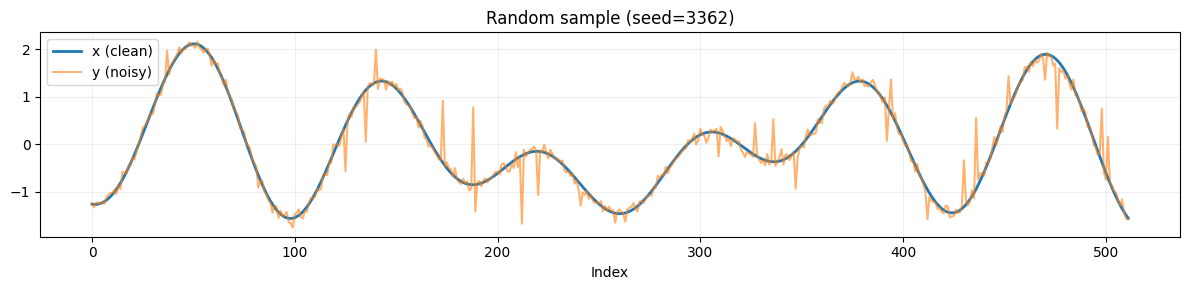

In [2]:
import random
import matplotlib.pyplot as plt
from src.data.signal_1d import Signal1DConfig, generate_pair

# Configuration des signaux synthétiques
cfg = Signal1DConfig(
    L=512,
    use_steps=True,
    use_spikes=True,
    do_standardize=True,
)

# Seed aléatoire (pour reproductibilité, tu peux aussi la fixer)
seed = random.randint(0, 10_000)

# Génération d’un seul signal
x_clean, y_noisy = generate_pair(cfg, seed=seed)

# Plot
plt.figure(figsize=(12, 3))
plt.plot(x_clean.numpy(), label="x (clean)", linewidth=2)
plt.plot(y_noisy.numpy(), label="y (noisy)", alpha=0.6)
plt.title(f"Random sample (seed={seed})")
plt.xlabel("Index")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

## **3.3. Expérience A — Rôle du préconditionnement multi-échelles**
### **Objectif de l’expérimentation**

Cette première expérimentation vise à étudier l’impact du **préconditionnement multi-échelles** induit par le choix des projections $P_i$ et des sous-espaces $V_i$ introduits dans le cadre théorique de l’article.

L’objectif est d’évaluer dans quelle mesure l’introduction d’une approximation initiale structurée du signal :
- améliore la stabilité de l’apprentissage,
- facilite la reconstruction des structures globales,
- et permet au réseau de se concentrer sur la correction des détails locaux.

Le problème considéré est un problème de **débruitage supervisé**, où l’on cherche à approximer l’opérateur inverse $y \mapsto x$ à partir de signaux synthétiques contrôlés (Section 3.2).

### **Backbone commun $f_\theta$ (MLP résiduel)**

Pour isoler l’effet du **préconditionnement**, toutes les variantes de l’Expérience A partagent exactement le même réseau de base $f_\theta$.  

#### **Architecture (forme et dimensions)**

Le réseau prend un signal bruité sous forme vectorielle et renvoie un vecteur de même dimension :
$$
f_\theta : \mathbb{R}^{L} \to \mathbb{R}^{L}, \qquad L = 512.
$$
En pratique, pour un batch :
$$
y \in \mathbb{R}^{B \times L} \quad \Rightarrow \quad f_\theta(y) \in \mathbb{R}^{B \times L}.
$$

Le backbone est un **MLP avec blocs résiduels** :

1. **Stem (projection vers une dimension cachée)**  
$$
h_0 = \sigma(W_{\text{in}}\, y + b_{\text{in}}), \qquad h_0 \in \mathbb{R}^{B \times H}.
$$

2. **Blocs résiduels (répétés $D$ fois)**  
Chaque bloc implémente :
$$
h \leftarrow h + g(\mathrm{LN}(h)),
$$
où $g$ est un petit MLP à deux couches linéaires avec non-linéarité (ReLU) et dropout, et où $\mathrm{LN}$ est une normalisation de couche (activée ici).

3. **Head (retour à la dimension $L$)**  
$$
f_\theta(y) = W_{\text{out}}\, h_D + b_{\text{out}} \in \mathbb{R}^{B \times L}.
$$

#### **Hyperparamètres utilisés**

- Dimension cachée : $H = 32$ (`hidden_dim=32`)
- Profondeur : $D = 2$ blocs résiduels (`depth=2`)
- Dropout : $0.05$
- LayerNorm : activée (`use_layernorm=true`)

#### **Schéma (vue compacte)**

$$
y \in \mathbb{R}^{B\times L}
\;\xrightarrow{\;\text{Linear }(L\to H)\;+\;\text{ReLU}\;}\;
h_0
\;\xrightarrow{\;\text{2 blocs résiduels}\;}\;
h_2
\;\xrightarrow{\;\text{Linear }(H\to L)\;}\;
f_\theta(y) \in \mathbb{R}^{B \times L}.
$$

Ainsi, dans l’Expérience A, **seule la manière d’utiliser $f_\theta$** change (baseline, résiduel, préconditionné), pas sa structure ni ses hyperparamètres.

### **Opérateur de débruitage appris $\hat{x}$ : baseline, résiduel et préconditionné**

Le backbone $f_\theta$ n’est pas utilisé de la même manière selon la formulation considérée.  
Dans l’implémentation, c’est l’objet `DenoiserOperator` qui définit l’opérateur effectif $\hat{x}(y)$ appliqué au signal bruité $y$.

On note $y$ le signal observé (bruité) et $\hat{x}$ la reconstruction du signal propre.



#### **1) Formulation baseline**

$$
\hat{x} = f_\theta(y).
$$

**Interprétation.**  
Le réseau apprend directement la reconstruction complète du signal propre à partir de l’observation bruitée, sans structure inductive explicite.



#### **2) Formulation résiduelle**

$$
\hat{x} = y + f_\theta(y).
$$

**Interprétation.**  
Le réseau apprend une correction additive par rapport à l’observation.  
Cette formulation est classique en apprentissage résiduel et vise à faciliter l’optimisation lorsque $y$ constitue déjà une approximation raisonnable de $x$.


#### **3) Formulation préconditionnée**

On introduit un opérateur déterministe $P$, appelé **préconditionneur**, qui fournit une approximation grossière $P(y)$ du signal propre.  
La reconstruction est alors définie par :

$$
\hat{x} = P(y) + f_\theta\bigl(y - P(y)\bigr).
$$

**Interprétation.**  
Le préconditionneur capture une structure simple du signal (typiquement de basse fréquence), tandis que le réseau apprend uniquement la correction résiduelle $y - P(y)$.  
Cette écriture met explicitement en évidence la décomposition *approximation grossière + correction*, au cœur des approches multi-échelles.


#### **Lien entre formulation résiduelle et préconditionnée**

La formulation résiduelle correspond au **cas particulier** de l’opérateur préconditionné lorsque le préconditionneur est l’identité :

$$
P(y) = y.
$$

Dans ce cas, on retrouve immédiatement :

$$
\hat{x} = y + f_\theta(y).
$$

Ainsi, **l’apprentissage résiduel apparaît comme une instance particulière du cadre préconditionné**, ce qui permet d’unifier les différentes variantes au sein d’une même écriture opératorielle.



#### **Préconditionneurs étudiés dans l’Expérience A**

Dans les expériences, seuls des préconditionneurs non triviaux sont considérés :

- **Moyenne glissante (moving average)**  
  $P(y)$ est un lissage par convolution 1D avec un noyau uniforme de taille $k$ (ici $k=9$), agissant comme un filtre passe-bas simple.

- **Haar low-pass (niveaux $\ell$)**  
  $P(y)$ est la reconstruction basse fréquence obtenue via une décomposition de Haar tronquée à $\ell$ niveaux (ici $\ell = 1$ ou $\ell = 3$), imposant explicitement une approximation multi-échelle.

---

#### **Résumé (vue opérateur)**

- **Baseline** : $y \;\rightarrow\; f_\theta \;\rightarrow\; \hat{x}$
- **Résiduel** : $y \;\rightarrow\; f_\theta \;\rightarrow\; y + f_\theta(y) \;\rightarrow\; \hat{x}$
- **Préconditionné** :
$$
y \xrightarrow{P} P(y),
\qquad
y \xrightarrow{} y - P(y) \xrightarrow{f_\theta} f_\theta(y - P(y)),
\qquad
\hat{x} = P(y) + f_\theta(y - P(y)).
$$

Cette écriture formalise explicitement l’idée d’une **approximation grossière suivie d’une correction apprise**, en cohérence avec l’analyse multi-échelle développée dans le cadre du U-Net unifié.

In [3]:
# Baseline (f(y)) + L1
!python main.py task@_global_=regression data=signal_1d model=denoiser_mlp \
  seed=0 trainer.deterministic=true trainer.benchmark=false \
  model.loss._target_=torch.nn.L1Loss \
  model.model.mode=baseline model.model.preconditioner=identity \
  output_id=signal1d_baseline_l1

# Residual (y + f(y)) + L1
!python main.py task@_global_=regression data=signal_1d model=denoiser_mlp \
  seed=0 trainer.deterministic=true trainer.benchmark=false \
  model.loss._target_=torch.nn.L1Loss \
  model.model.mode=residual model.model.preconditioner=identity \
  output_id=signal1d_residual_l1

# Preconditioned + Haar (L=1) + L1
!python main.py task@_global_=regression data=signal_1d model=denoiser_mlp \
  seed=0 trainer.deterministic=true trainer.benchmark=false \
  model.loss._target_=torch.nn.L1Loss \
  model.model.mode=preconditioned model.model.preconditioner=haar model.model.haar_levels=1 \
  output_id=signal1d_precond_haar1_l1

# Preconditioned + Haar (L=3) + L1
!python main.py task@_global_=regression data=signal_1d model=denoiser_mlp \
  seed=0 trainer.deterministic=true trainer.benchmark=false \
  model.loss._target_=torch.nn.L1Loss \
  model.model.mode=preconditioned model.model.preconditioner=haar model.model.haar_levels=3 \
  output_id=signal1d_precond_haar3_l1

# Preconditioned + MA (k=9) + L1
!python main.py task@_global_=regression data=signal_1d model=denoiser_mlp \
  seed=0 trainer.deterministic=true trainer.benchmark=false \
  model.loss._target_=torch.nn.L1Loss \
  model.model.mode=preconditioned model.model.preconditioner=ma model.model.ma_kernel_size=9 \
  output_id=signal1d_precond_ma9_l1

Seed set to 0
seed: 0
output_dir: .cache
output_id: signal1d_baseline_l1
trainer:
  _target_: pytorch_lightning.Trainer
  max_epochs: 15
  accelerator: auto
  log_every_n_steps: 10
  check_val_every_n_epoch: 1
  limit_val_batches: 1.0
  deterministic: true
  benchmark: false
  enable_checkpointing: true
  enable_progress_bar: true
  callbacks:
  - _target_: pytorch_lightning.callbacks.EarlyStopping
    monitor: val_loss
    mode: min
    patience: 10
  - _target_: pytorch_lightning.callbacks.ModelCheckpoint
    monitor: val_loss
    mode: min
    save_top_k: 1
    dirpath: ./${output_dir}/checkpoints
    filename: ${now:%Y-%m-%d_%H-%M-%S}-epoch={epoch}-val_loss={val_loss:.6f}
model:
  _target_: src.models.regression_model.RegressionModel
  model:
    _target_: src.models.regressors.DenoiserOperator
    mode: baseline
    preconditioner: identity
    ma_kernel_size: 9
    haar_levels: 3
    net:
      _target_: src.models.regressors.MLPResNet
      input_dim: ${data.d}
      output_dim:

### **Analyse des résultats**

Les différents modèles entraînés sont comparés selon trois axes complémentaires :

- **la dynamique d’apprentissage**, à partir des courbes de perte d’entraînement et de validation ;
- **la qualité de reconstruction**, évaluée qualitativement sur des signaux synthétiques fixés ;
- **la performance quantitative**, mesurée par l’erreur quadratique moyenne, ainsi que par une décomposition fréquentielle distinguant basses et hautes fréquences.

L’ensemble des comparaisons est réalisé à configuration d’entraînement identique, afin d’isoler l’impact des choix architecturaux étudiés. Les modèles analysés correspondent, pour chaque variante, au checkpoint associé à la meilleure performance en validation.

In [10]:
CACHE_DIR = "./.cache"
LOG_DIR = os.path.join(CACHE_DIR, "lightning_logs")
CKPT_DIR = os.path.join(CACHE_DIR, "checkpoints")

RUN_VERSION = {
    "Baseline (f(y))": "version_0",
    "Residual (y + f(y))": "version_1",
    "Precond Haar (L=1)": "version_2",
    "Precond Haar (L=3)": "version_3",
    "Precond MA (k=9)": "version_4",
}

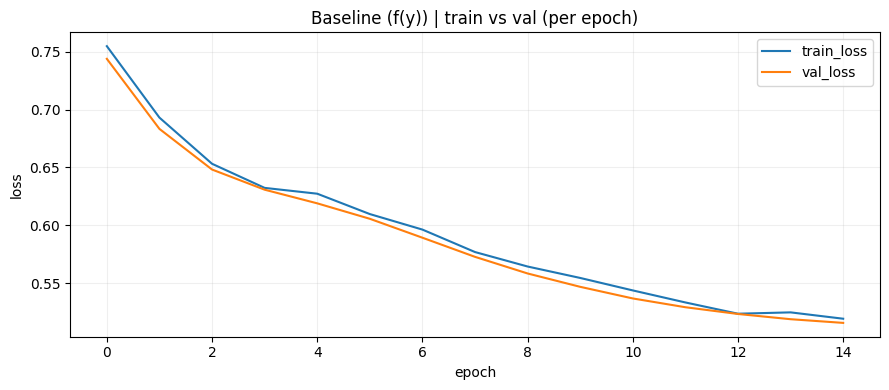

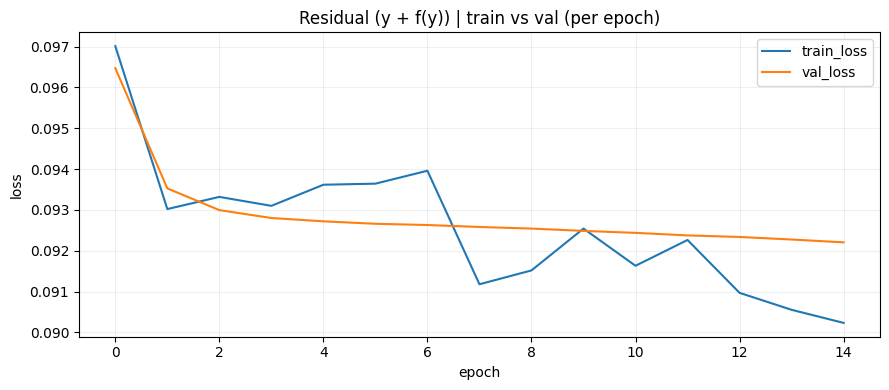

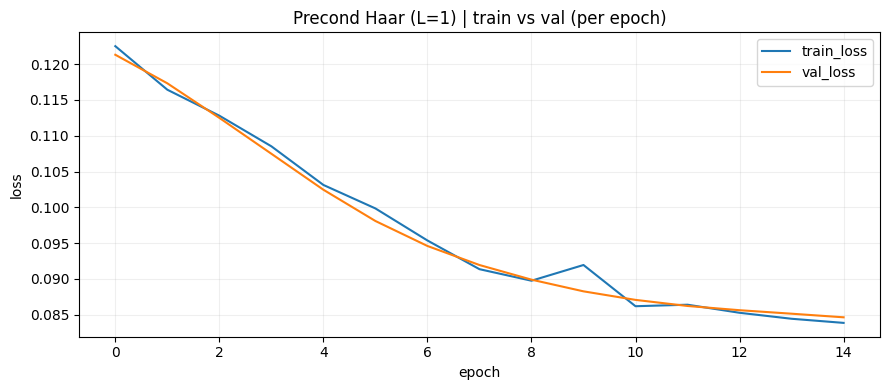

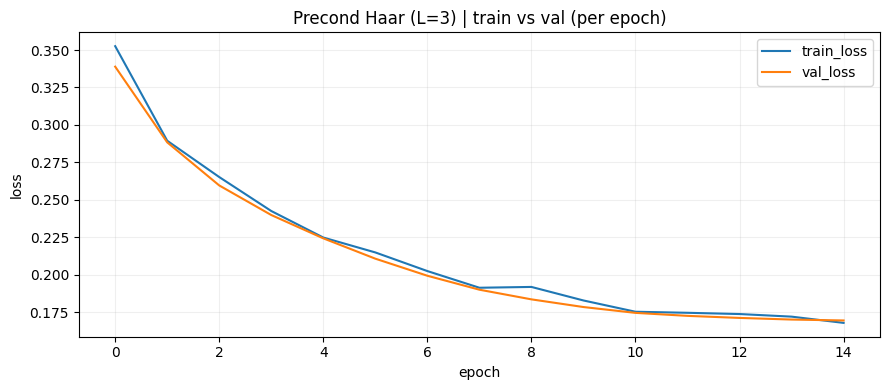

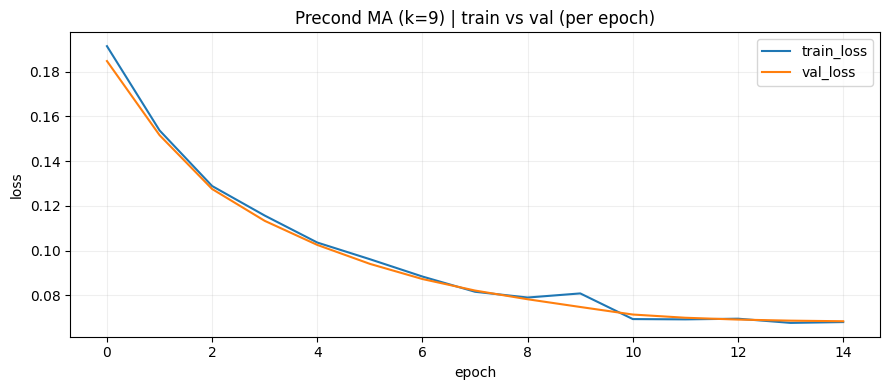

In [11]:
plot_train_val_per_model(RUN_VERSION, log_dir=LOG_DIR)

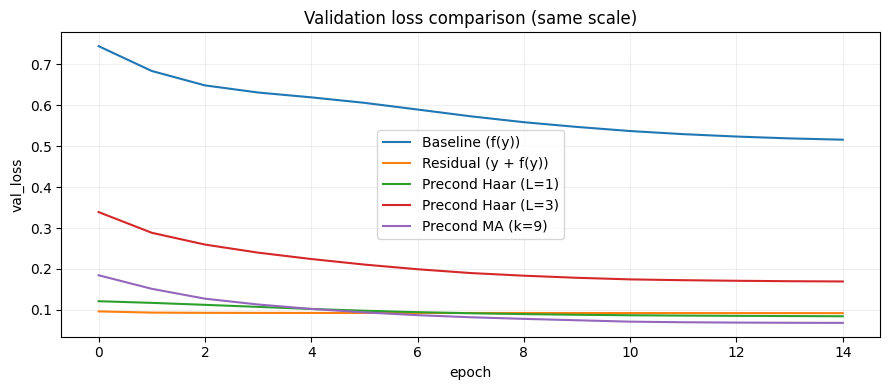

In [12]:
plot_val_loss_overlay(RUN_VERSION, log_dir=LOG_DIR)

### **Analyse des courbes d’apprentissage**

Les courbes train/validation mettent en évidence des comportements nettement différents selon la formulation de l’opérateur de débruitage.

**Baseline ($\hat{x} = f(y)$).**  
La perte décroît de manière régulière mais reste élevée sur l’ensemble de l’entraînement. Le réseau apprend une reconstruction globale du signal, sans structure inductive explicite, ce qui rend l’optimisation plus difficile et limite les performances finales.

**Formulation résiduelle ($\hat{x} = y + f(y)$).**  
La convergence est rapide et stable, avec un écart train/validation très faible. Le modèle exploite le fait que le signal bruité constitue déjà une bonne approximation du signal propre. En revanche, la perte atteint rapidement un plateau, ce qui suggère une capacité limitée à corriger les composantes les plus complexes du bruit.

**Préconditionnement Haar ($L=1$).**  
Les courbes montrent une convergence régulière et bien alignée entre train et validation. Le préconditionneur fournit une approximation grossière efficace, ce qui simplifie la tâche du réseau. Les performances finales sont supérieures à celles de la formulation résiduelle, tout en restant stables.

**Préconditionnement Haar ($L=3$).**  
La perte initiale est plus élevée, traduisant une approximation initiale plus grossière. En revanche, la décroissance est marquée et régulière. Le réseau apprend à corriger une décomposition multi-échelle plus agressive, ce qui améliore la reconstruction des structures fines au prix d’une optimisation légèrement plus lente.

**Préconditionnement par moyenne glissante (MA, $k=9$).**  
Cette formulation donne les meilleurs résultats dans cette expérience. La convergence est rapide, la perte finale est la plus basse, et l’écart entre train et validation reste faible. Le lissage agit comme un préconditionneur basse fréquence très efficace, laissant au réseau une correction résiduelle bien conditionnée.


### **Comparaison globale des pertes de validation**

La superposition des courbes de validation met en évidence une hiérarchie claire des performances :

- La formulation **baseline** est systématiquement dominée.
- La formulation **résiduelle** améliore nettement la convergence, mais reste inférieure aux approches préconditionnées.
- Les modèles **préconditionnés** obtiennent les meilleures performances, avec un avantage marqué pour la moyenne glissante et le préconditionnement Haar peu profond.
- Un préconditionnement plus profond (Haar $L=3$) reste bénéfique, mais introduit une difficulté d’optimisation supplémentaire.

---


Ces résultats montrent que l’introduction d’un préconditionneur explicite améliore significativement l’apprentissage du débruitage. La décomposition *approximation grossière + correction apprise* permet au réseau de se concentrer sur les composantes réellement informatives du signal, ce qui se traduit par une convergence plus rapide et une meilleure généralisation.

In [13]:
models_info = load_best_models(
    run_version=RUN_VERSION,
    ckpt_dir=CKPT_DIR,
    log_dir=LOG_DIR,
    device=device,
)


for name, info in models_info.items():
    print(f"{name} | best_epoch={info['best_epoch']} | best_val={info['best_val']:.6f} | ckpt={os.path.basename(info['ckpt'])}")

Baseline (f(y)) | best_epoch=14 | best_val=0.515621 | ckpt=2026-01-30_23-43-34-epoch=epoch=14-val_loss=val_loss=0.515621.ckpt
Residual (y + f(y)) | best_epoch=14 | best_val=0.092207 | ckpt=2026-01-30_23-46-51-epoch=epoch=14-val_loss=val_loss=0.092207.ckpt
Precond Haar (L=1) | best_epoch=14 | best_val=0.084631 | ckpt=2026-01-30_23-50-09-epoch=epoch=14-val_loss=val_loss=0.084631.ckpt
Precond Haar (L=3) | best_epoch=14 | best_val=0.169548 | ckpt=2026-01-30_23-53-23-epoch=epoch=14-val_loss=val_loss=0.169548.ckpt
Precond MA (k=9) | best_epoch=14 | best_val=0.068429 | ckpt=2026-01-30_23-56-43-epoch=epoch=14-val_loss=val_loss=0.068429.ckpt


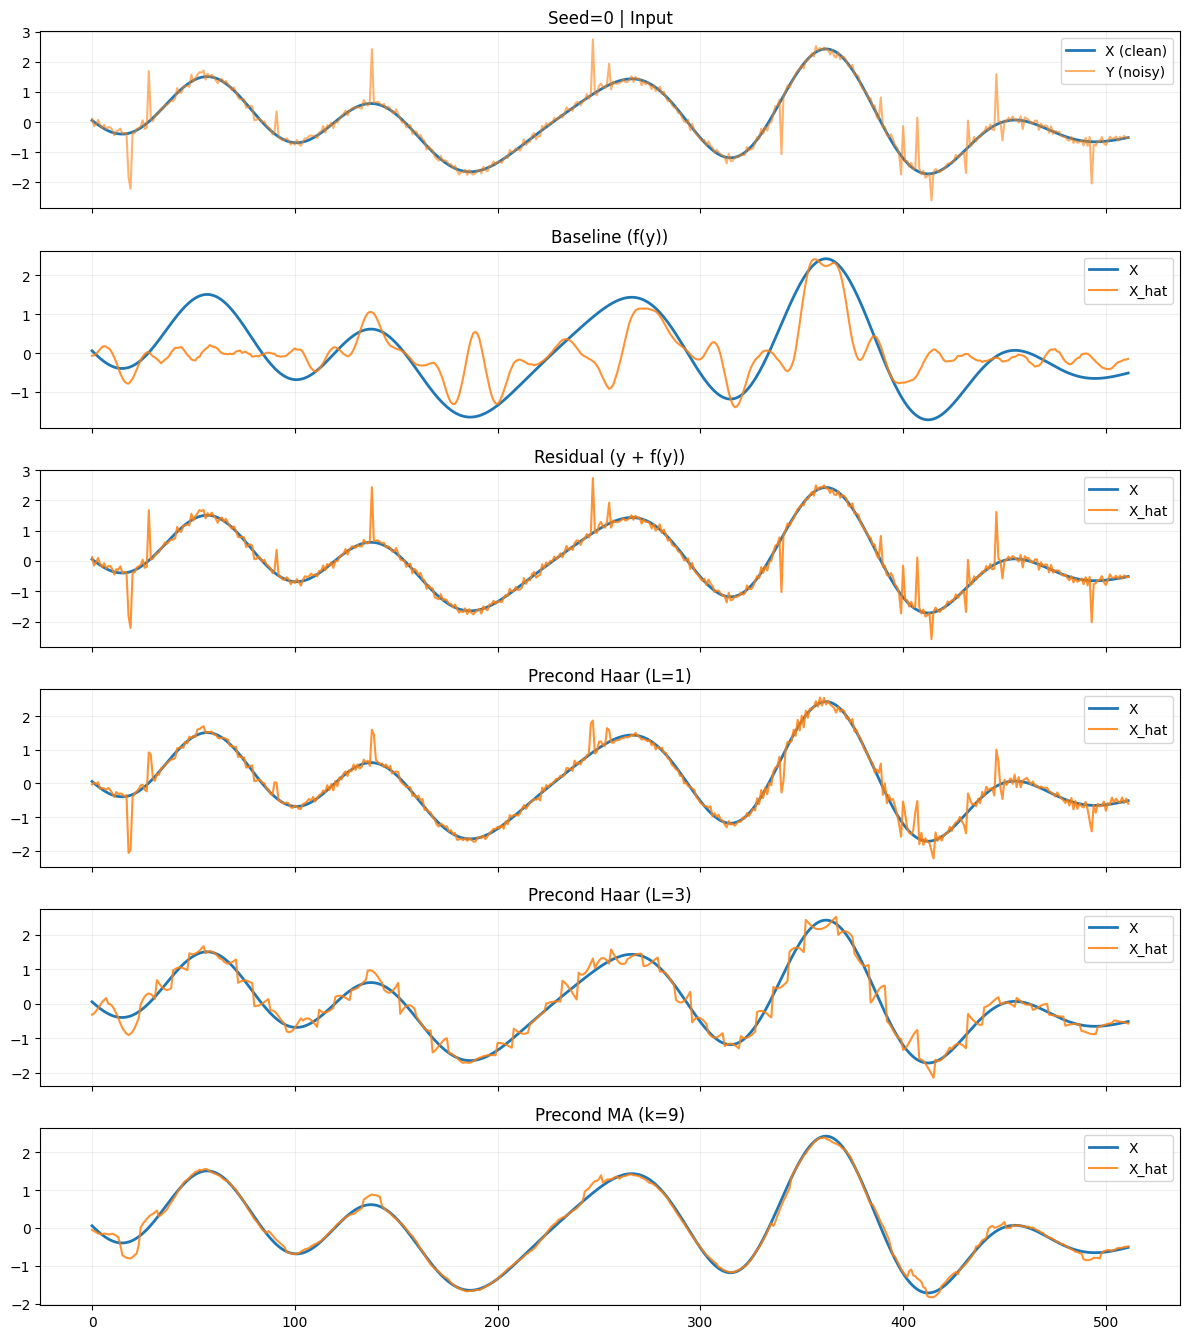

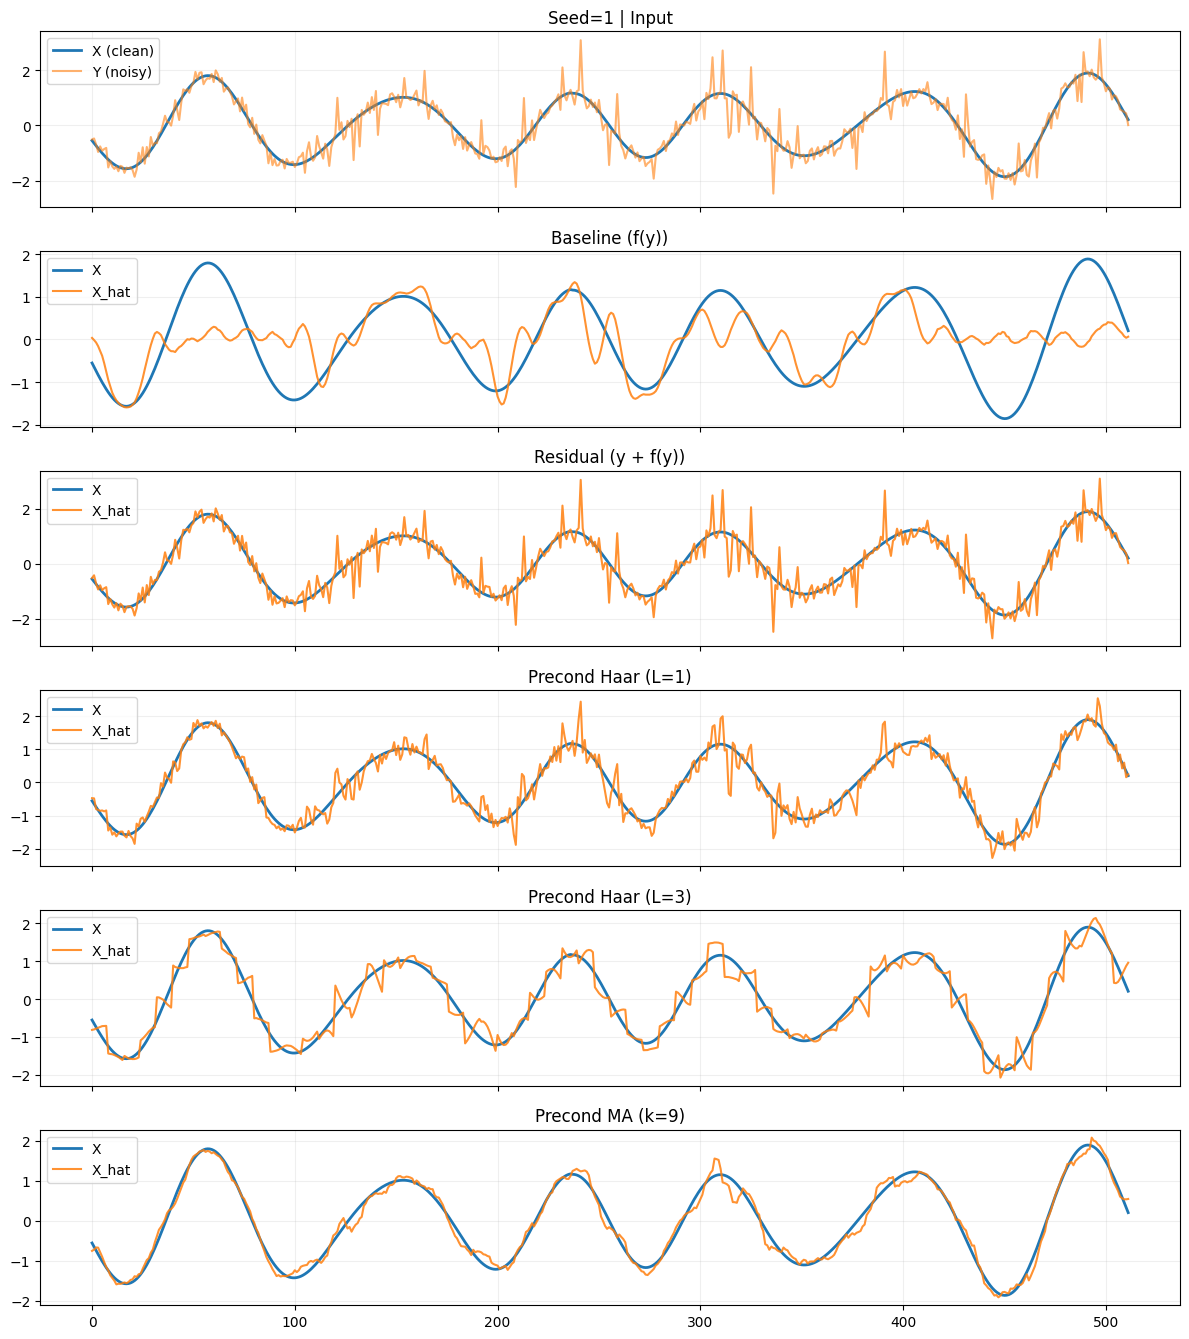

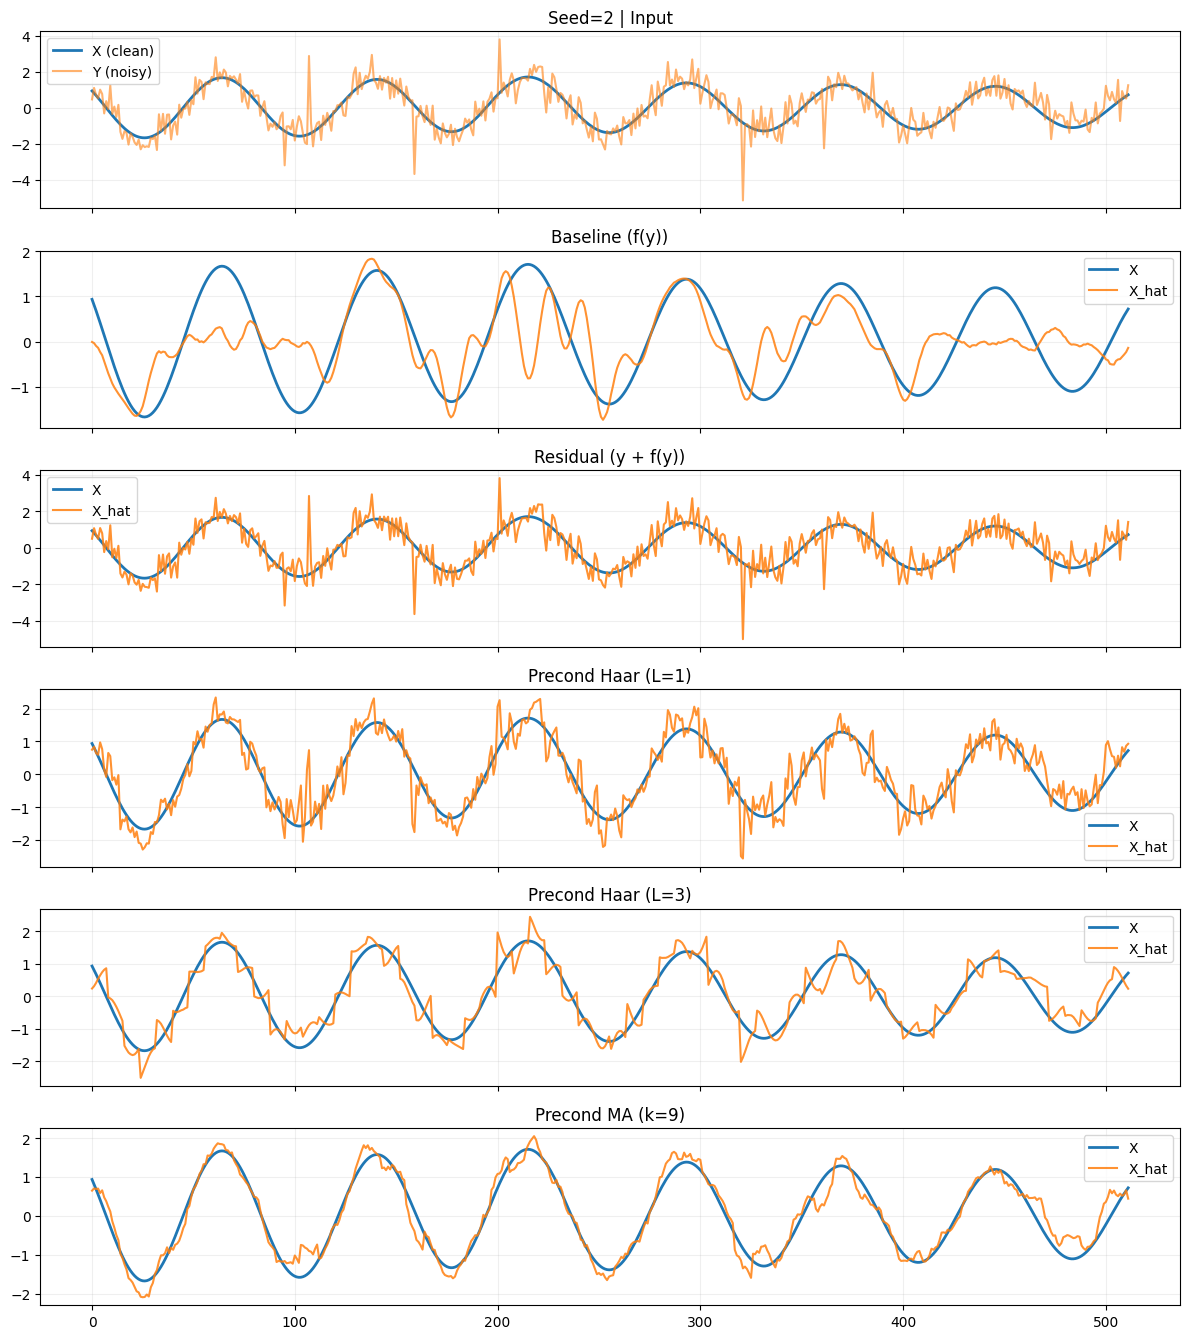

In [14]:
cfg = Signal1DConfig(L=512, use_steps=True, use_spikes=True, do_standardize=True)
seeds_visu = [0, 1, 2]

Y_fix, X_fix = make_fixed_batch(cfg, seeds_visu, device=device) 


models = {name: info["model"] for name, info in models_info.items()}
plot_reconstructions(models, Y_fix, X_fix, seeds_visu)

### **Analyse qualitative des reconstructions**

Les figures ci-dessus illustrent les reconstructions obtenues sur des signaux synthétiques non utilisés pendant l’entraînement.

**Baseline ($\hat{x}=f(y)$).**  
La reconstruction est globalement insuffisante. Le signal est trop lissé, les amplitudes sont mal restituées et la dynamique globale du signal propre n’est pas correctement suivie. Le réseau peine à apprendre directement la transformation complète de $y$ vers $x$.

**Formulation résiduelle ($\hat{x}=y+f(y)$).**  
L’ajout du chemin résiduel améliore nettement la qualité visuelle. La structure globale du signal est bien mieux respectée, mais des artefacts haute fréquence subsistent, en particulier autour des pics impulsionnels, indiquant une rétention partielle du bruit.

**Préconditionnement Haar ($L=1$).**  
Le préconditionnement permet une reconstruction plus stable, avec une meilleure séparation entre structure globale et bruit. Le signal reconstruit suit fidèlement $x$ tout en limitant les oscillations parasites.

**Préconditionnement Haar ($L=3$).**  
L’augmentation du nombre de niveaux accentue le lissage. Les composantes de basse fréquence sont très bien capturées, au prix d’une atténuation des variations rapides, ce qui entraîne une perte de détails fins.

**Préconditionnement par moyenne glissante (MA, $k=9$).**  
Cette configuration produit les reconstructions les plus proches du signal propre. Le bruit impulsionnel est fortement réduit et la forme globale est correctement préservée, avec peu d’artefacts visibles.

**Conclusion.**  
Les résultats qualitatifs montrent clairement l’intérêt du préconditionnement. En fournissant une approximation grossière du signal, il simplifie la tâche du réseau et améliore la qualité des reconstructions par rapport à la baseline et à la formulation résiduelle.

,name,mse_x,mae_x,r2_x
0,Precond MA (k=9),0.034026,0.129493,0.965974
1,Precond Haar (L=3),0.080005,0.213345,0.919995
2,Precond Haar (L=1),0.118947,0.223378,0.881053
3,Residual (y + f(y)),0.226868,0.277693,0.773132
4,Baseline (f(y)),0.594312,0.570356,0.405688


,name,mse_lf,mse_hf,nmse_lf,nmse_hf
0,Precond MA (k=9),0.022887,0.011139,0.023520,0.413824
1,Precond Haar (L=3),0.032025,0.047980,0.032911,1.782462
2,Precond Haar (L=1),0.032060,0.086887,0.032947,3.227839
3,Residual (y + f(y)),0.032067,0.194801,0.032954,7.236814
4,Baseline (f(y)),0.542651,0.051661,0.557663,1.919182


,name,mse_y,copy_ratio_mse,snr_gain_db
0,Precond MA (k=9),0.201631,5.925722,8.242952
1,Precond Haar (L=3),0.224007,2.799906,4.529928
2,Precond Haar (L=1),0.111469,0.937127,2.807562
3,Residual (y + f(y)),0.002416,0.010648,0.003372
4,Baseline (f(y)),0.783181,1.317794,-4.179040


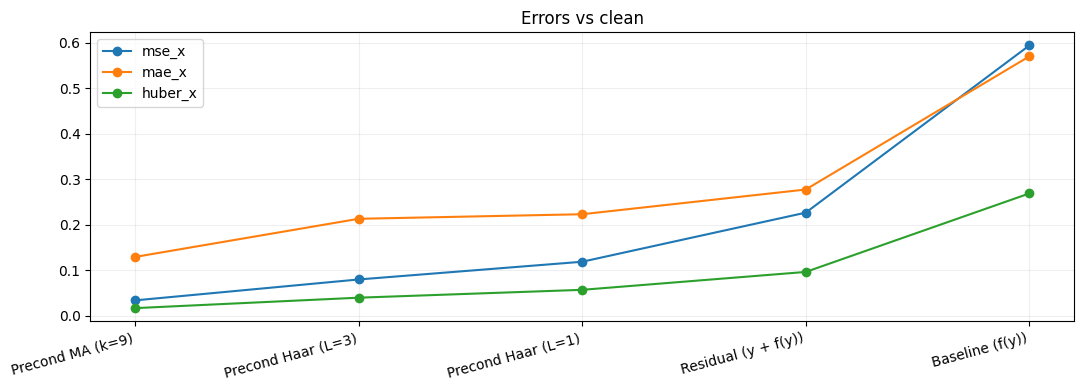

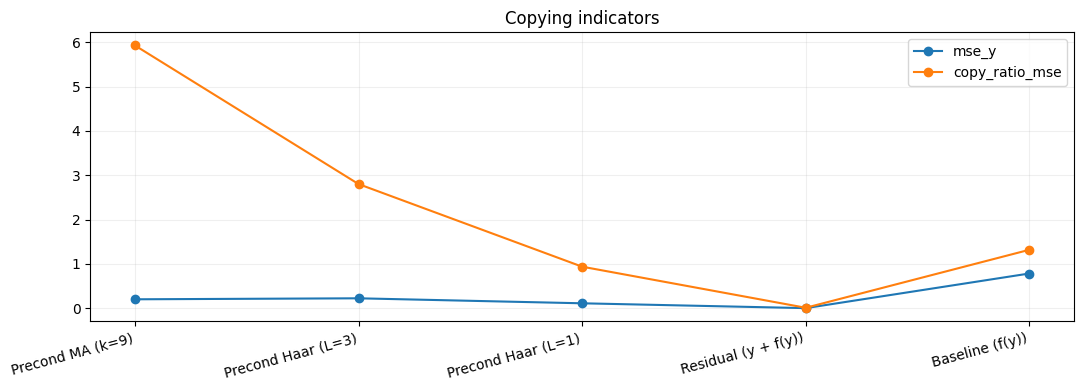

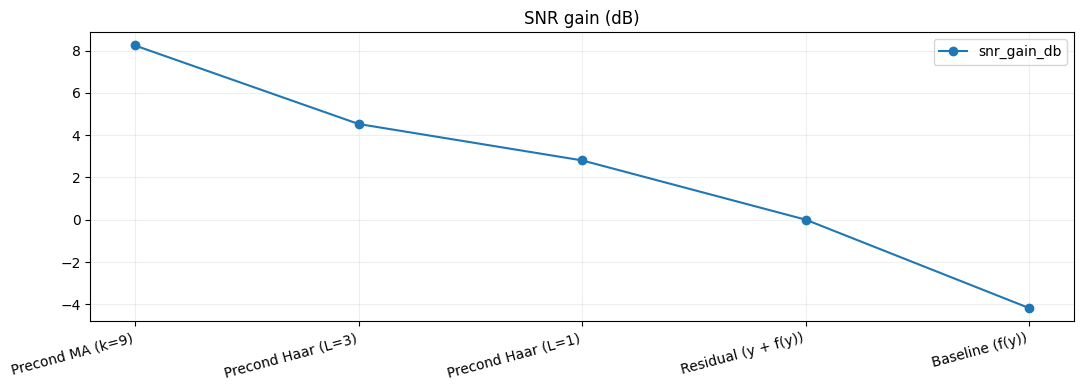

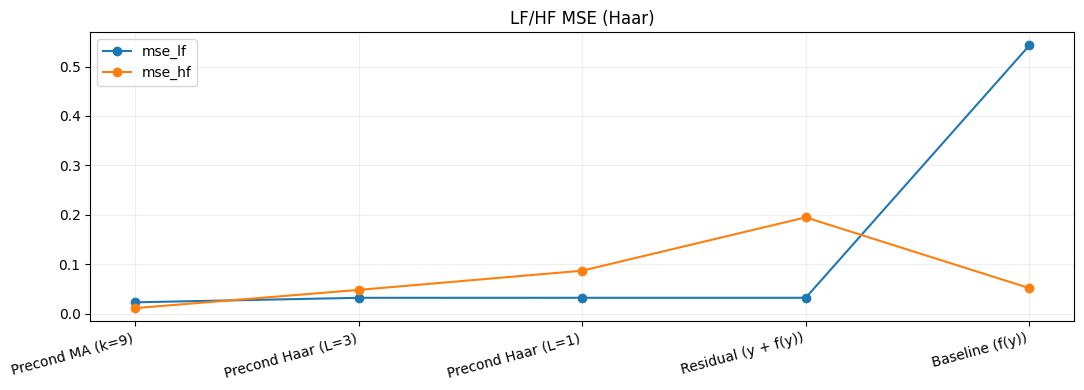

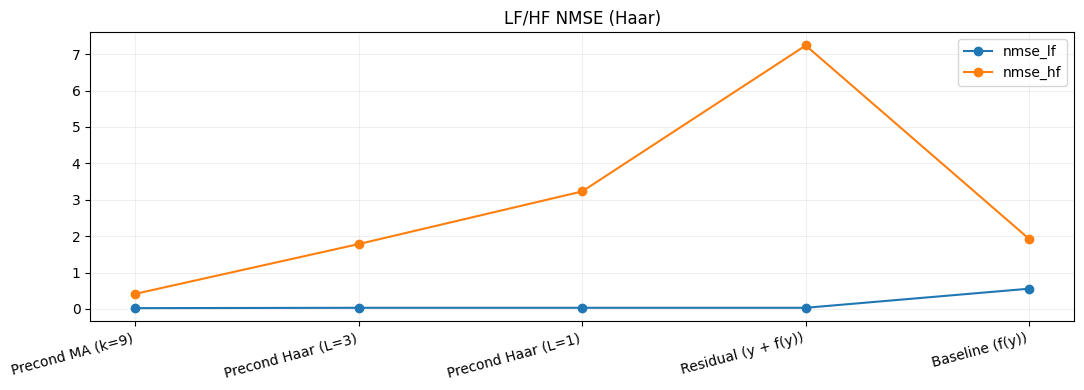

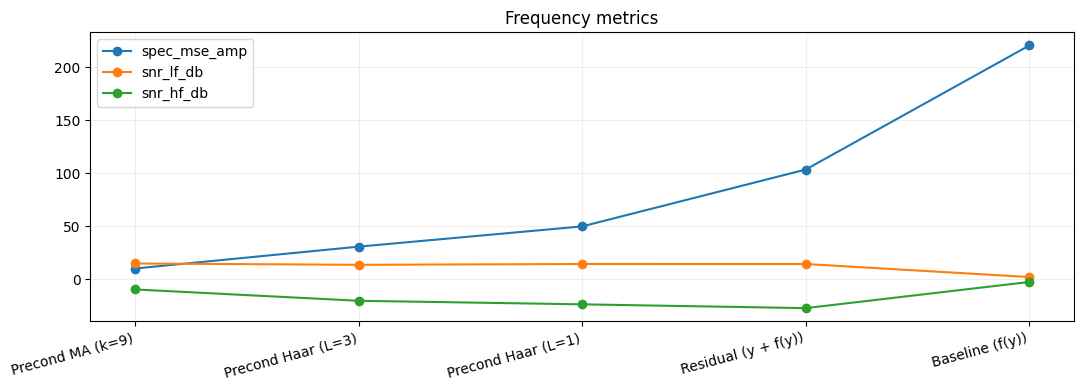

In [22]:
df_metrics = eval_models_table(
    models=models,
    Y=Y_fix,
    X=X_fix,
    lf_levels=3,
    huber_delta=1.0,
    f_split=0.15,
)

#  Tableau principal 
df_global = (
    df_metrics[["name", "mse_x", "mae_x", "r2_x"]]
    .sort_values("mse_x")
    .reset_index(drop=True)
)

order = df_global["name"].tolist()

# Tableau LF/HF (Haar)
df_lf_hf = (
    df_metrics[["name", "mse_lf", "mse_hf", "nmse_lf", "nmse_hf"]]
    .set_index("name")
    .loc[order]
    .reset_index()
)

# Tableau bruit / copie
df_noise = (
    df_metrics[["name", "mse_y", "copy_ratio_mse", "snr_gain_db"]]
    .set_index("name")
    .loc[order]
    .reset_index()
)
display(df_global)
display(df_lf_hf)
display(df_noise)
plot_metric_lines(df_metrics, ["mse_x", "mae_x", "huber_x"], title="Errors vs clean")
plot_metric_lines(df_noise, ["mse_y", "copy_ratio_mse"], title="Copying indicators")
plot_metric_lines(df_noise, ["snr_gain_db"], title="SNR gain (dB)")
plot_metric_lines(df_lf_hf, ["mse_lf", "mse_hf"], title="LF/HF MSE (Haar)")
plot_metric_lines(df_lf_hf, ["nmse_lf", "nmse_hf"], title="LF/HF NMSE (Haar)")
plot_metric_lines(df_metrics, ["spec_mse_amp", "snr_lf_db", "snr_hf_db"], title="Frequency metrics")

### **Indicateurs d’évaluation**

L’évaluation repose sur un ensemble volontairement restreint mais complémentaire d’indicateurs, afin de caractériser à la fois la précision globale de la reconstruction, le comportement fréquentiel du modèle et son rapport au bruit d’entrée.

**Erreurs globales (par rapport au signal propre X)**  
- **MSE / MAE / Huber** : mesurent l’erreur de reconstruction moyenne.  
  La MSE pénalise fortement les erreurs importantes, tandis que la MAE et la perte de Huber sont plus robustes aux valeurs aberrantes.
- **R²** : indique la proportion de variance du signal propre expliquée par la reconstruction.

**Indicateurs de copie du bruit**  
- **MSE\_y** : erreur entre la sortie du modèle et l’entrée bruitée Y.  
- **copy\_ratio\_mse = MSE(x̂, Y) / MSE(x̂, X)** : permet de détecter un comportement de simple copie de l’entrée.
- **SNR gain (dB)** : différence de rapport signal/bruit entre l’entrée et la sortie. Une valeur positive indique un débruitage effectif.

**Analyse multi-échelle (décomposition Haar)**  
- **MSE\_LF / MSE\_HF** : erreurs respectivement sur les composantes basses et hautes fréquences.
- **NMSE\_LF / NMSE\_HF** : versions normalisées permettant de comparer l’erreur relativement à l’énergie de chaque bande.

**Indicateurs fréquentiels**  
- **Spectral MSE (amplitude)** : mesure l’écart entre les spectres en amplitude, indépendamment de la phase.
- **SNR\_LF / SNR\_HF** : rapport signal/bruit évalué séparément sur les basses et hautes fréquences.

### **Interprétation des résultats**

Les résultats montrent des comportements nettement distincts selon les architectures.

Le modèle **Baseline (f(y))** présente des erreurs élevées et un gain de SNR négatif, ce qui confirme qu’il ne parvient pas à séparer efficacement le signal du bruit. Il dégrade en particulier les basses fréquences, comme l’indiquent les fortes valeurs de MSE_LF et NMSE_LF.

Le modèle **Residual (y + f(y))** améliore la stabilité visuelle et limite les artefacts, mais son gain de SNR est quasi nul. Les indicateurs de copie suggèrent qu’il conserve une part importante du bruit d’entrée, en particulier dans les hautes fréquences.

Les architectures avec **préconditionnement Haar** apportent une amélioration claire.  
- Avec **L = 1**, le compromis est favorable mais reste imparfait sur les hautes fréquences.  
- Avec **L = 3**, la reconstruction est plus régulière, avec une meilleure séparation fréquentielle, au prix d’une légère perte de détails fins.

Le modèle **Precond MA (k = 9)** se détache nettement. Il obtient les plus faibles erreurs globales, le meilleur gain de SNR et une excellente maîtrise des basses fréquences, tout en limitant fortement la copie du bruit. Les indicateurs fréquentiels confirment une réduction efficace de l’énergie parasite, sans sur-lissage excessif.


### **Conclusion de l’expérimentation A**

Cette première expérimentation met en évidence l’impact déterminant de l’architecture et du préconditionnement sur la capacité de débruitage des modèles.  
Le modèle de base, qui apprend directement une reconstruction à partir du signal bruité, échoue à isoler correctement la composante utile et tend à amplifier ou conserver le bruit. L’ajout d’une connexion résiduelle améliore la stabilité mais reste insuffisant pour obtenir un gain de SNR significatif.

À l’inverse, l’introduction d’un préconditionnement explicite du signal modifie profondément le comportement du réseau. Les préconditionnements de type Haar favorisent une meilleure séparation fréquentielle, tandis que le préconditionnement par moyenne mobile fournit le compromis le plus efficace entre réduction du bruit, fidélité du signal reconstruit et stabilité fréquentielle.

Ces observations sont cohérentes avec les hypothèses du papier, selon lesquelles la reformulation du problème via un opérateur de préconditionnement facilite l’apprentissage de la partie résiduelle pertinente. Les résultats expérimentaux confirment ainsi que cette approche ne constitue pas seulement un choix architectural, mais un élément central pour orienter efficacement l’optimisation du réseau.

## **3.5. Expérience B : rôle des connexions de saut (skip connections)**

### **Objectif**

Cette expérience vise à isoler le rôle des **connexions de saut** dans un U-Net 1D appliqué au débruitage de signaux.

Deux architectures sont comparées, strictement identiques à l’exception d’un unique choix architectural :

- **U-Net skip ON** : connexions de saut activées (architecture U-Net standard),
- **U-Net skip OFF** : connexions de saut désactivées (ablation).

L’objectif est d’analyser dans quelle mesure les skip connections influencent :
- la stabilité de l’optimisation,
- la qualité globale de la reconstruction,
- ainsi que la répartition des erreurs entre basses et hautes fréquences.

### **Backbone architectural**

Les deux modèles reposent sur le même backbone **U-Net 1D**, structuré selon une architecture encodeur–décodeur symétrique.  
L’encodeur est composé de blocs convolutionnels 1D suivis d’un sous-échantillonnage par max-pooling, tandis que le décodeur effectue un sur-échantillonnage linéaire suivi de convolutions symétriques.  

La largeur des couches est définie par la séquence :
\[
[16,\;32,\;64,\;128],
\]
avec un goulot d’étranglement de largeur doublée.

Dans la configuration *skip ON*, les activations de l’encodeur sont concaténées aux activations du décodeur aux résolutions correspondantes.  
Dans la configuration *skip OFF*, ces connexions sont explicitement neutralisées en les remplaçant par des tenseurs nuls de même dimension.

Ainsi, les deux architectures partagent exactement la même profondeur, la même capacité et les mêmes paramètres d’optimisation, et ne diffèrent que par la présence effective des connexions de saut.

### **Protocole**

Les deux modèles sont entraînés :
- sur exactement les mêmes données (Section 3.2),
- avec le même optimiseur et les mêmes hyperparamètres,
- et la sélection du meilleur modèle repose sur la perte de validation.

Les commandes Hydra associées permettent de lancer séparément les deux entraînements.

In [19]:
# Skip on + L1
!python main.py task@_global_=regression data=signal_1d model=denoiser_unet1d \
  seed=0 trainer.deterministic=true trainer.benchmark=false \
  data.datamodule.use_steps=true data.datamodule.use_spikes=true data.datamodule.do_standardize=true \
  data.datamodule.impulsive_prob_min=0.0 data.datamodule.impulsive_prob_max=0.0 \
  data.datamodule.sigma_noise_min=0.10 data.datamodule.sigma_noise_max=0.30 \
  model.loss._target_=torch.nn.L1Loss \
  model.model.skip_mode=on \
  output_id=signal1d_unet_skip_on_gauss_l1

# Skip off + L1
!python main.py task@_global_=regression data=signal_1d model=denoiser_unet1d \
  seed=0 trainer.deterministic=true trainer.benchmark=false \
  data.datamodule.use_steps=true data.datamodule.use_spikes=true data.datamodule.do_standardize=true \
  data.datamodule.impulsive_prob_min=0.0 data.datamodule.impulsive_prob_max=0.0 \
  data.datamodule.sigma_noise_min=0.10 data.datamodule.sigma_noise_max=0.30 \
  model.loss._target_=torch.nn.L1Loss \
  model.model.skip_mode=off \
  output_id=signal1d_unet_skip_off_gauss_l1

Seed set to 0
seed: 0
output_dir: .cache
output_id: signal1d_unet_skip_on_gauss_l1
trainer:
  _target_: pytorch_lightning.Trainer
  max_epochs: 15
  accelerator: auto
  log_every_n_steps: 10
  check_val_every_n_epoch: 1
  limit_val_batches: 1.0
  deterministic: true
  benchmark: false
  enable_checkpointing: true
  enable_progress_bar: true
  callbacks:
  - _target_: pytorch_lightning.callbacks.EarlyStopping
    monitor: val_loss
    mode: min
    patience: 10
  - _target_: pytorch_lightning.callbacks.ModelCheckpoint
    monitor: val_loss
    mode: min
    save_top_k: 1
    dirpath: ./${output_dir}/checkpoints
    filename: ${now:%Y-%m-%d_%H-%M-%S}-epoch={epoch}-val_loss={val_loss:.6f}
model:
  _target_: src.models.regression_model.RegressionModel
  model:
    _target_: src.models.unet_1d.UNet1D
    in_channels: 1
    out_channels: 1
    dims:
    - 16
    - 32
    - 64
    - 128
    skip_mode: 'on'
  loss:
    _target_: torch.nn.L1Loss
  optimizer:
    _target_: torch.optim.AdamW
    

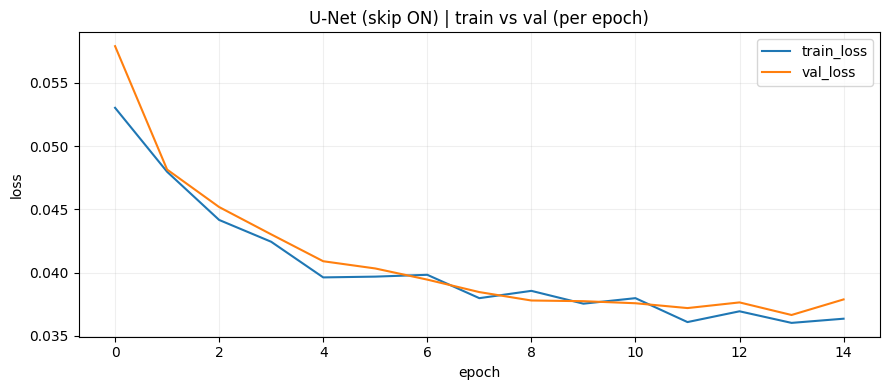

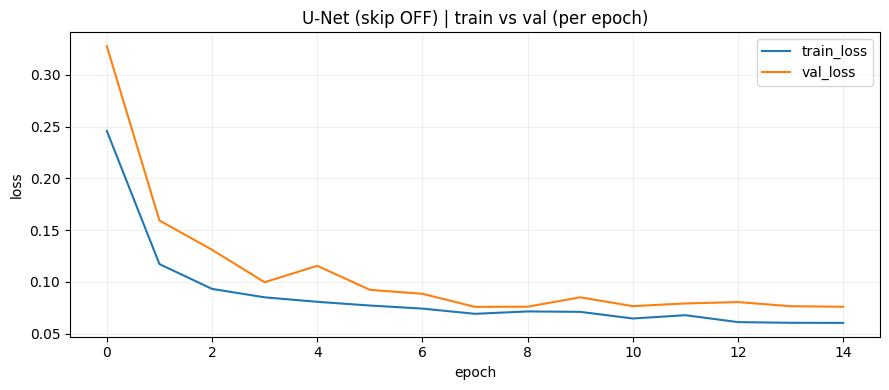

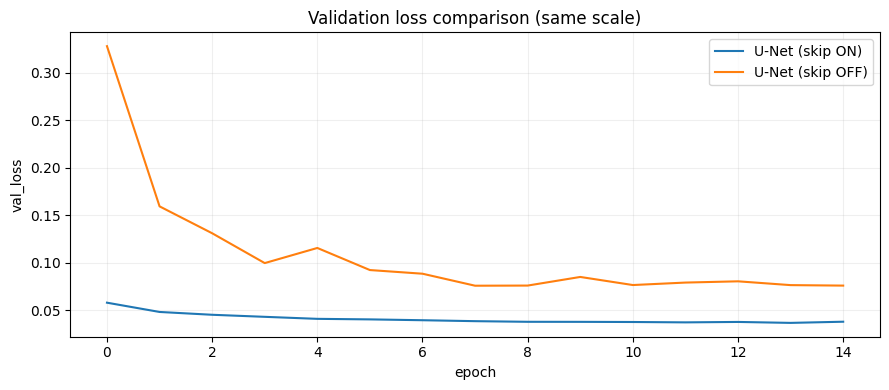

In [20]:
RUN_VERSION2 = {
    "U-Net (skip ON)":  "version_5",
    "U-Net (skip OFF)": "version_6",
}
plot_train_val_per_model(RUN_VERSION2, log_dir=LOG_DIR)
plot_val_loss_overlay(RUN_VERSION2, log_dir=LOG_DIR)

### **Analyse des courbes de loss**

L’U-Net avec **connexions de saut activées** converge plus rapidement et vers une **perte de validation nettement plus faible** que sa version sans skips. Les courbes train/val restent proches tout au long de l’entraînement, ce qui indique une optimisation stable et peu de sur-apprentissage.

À l’inverse, le modèle **sans skip connections** présente une perte de validation sensiblement plus élevée et plus fluctuante. L’écart persistant entre train et validation suggère une difficulté accrue à reconstruire correctement le signal à partir des seules représentations profondes.

Ces résultats confirment que les connexions de saut jouent un rôle clé dans la transmission de l’information à haute résolution, facilitant à la fois l’optimisation et la qualité de reconstruction globale.

In [23]:
models_info = load_best_models(
    run_version=RUN_VERSION2,
    ckpt_dir=CKPT_DIR,
    log_dir=LOG_DIR,
    device=device,
)


for name, info in models_info.items():
    print(f"{name} | best_epoch={info['best_epoch']} | best_val={info['best_val']:.6f} | ckpt={os.path.basename(info['ckpt'])}")

U-Net (skip ON) | best_epoch=13 | best_val=0.036660 | ckpt=2026-01-31_00-01-45-epoch=epoch=13-val_loss=val_loss=0.036660.ckpt
U-Net (skip OFF) | best_epoch=7 | best_val=0.075764 | ckpt=2026-01-31_00-09-51-epoch=epoch=7-val_loss=val_loss=0.075764.ckpt


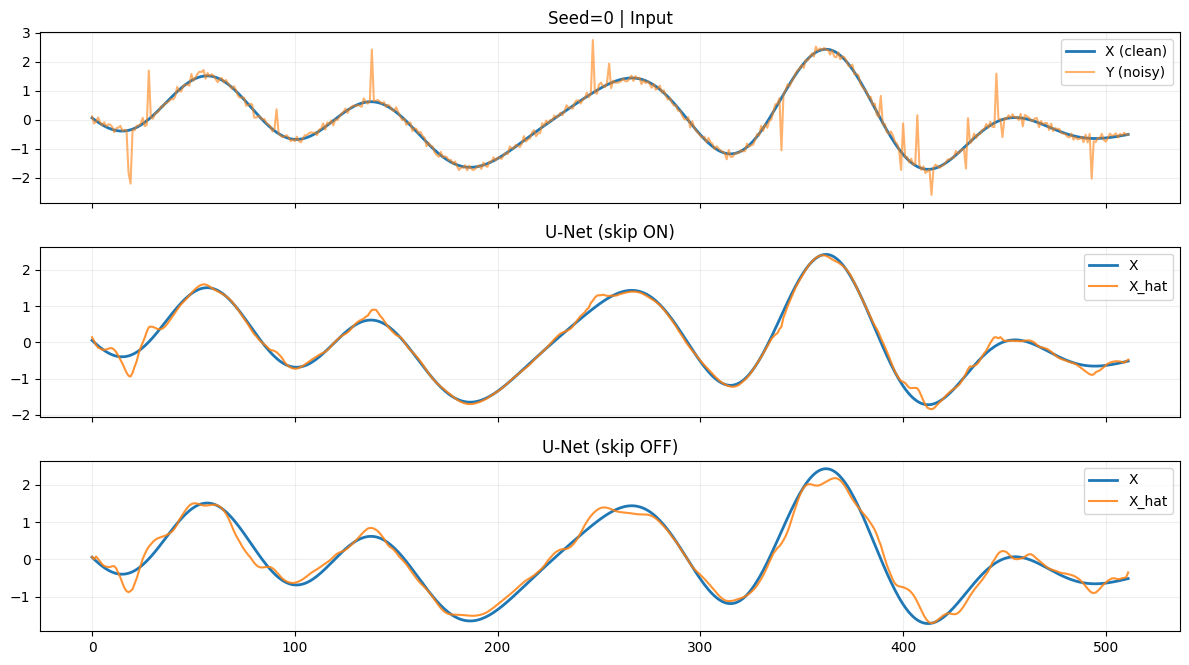

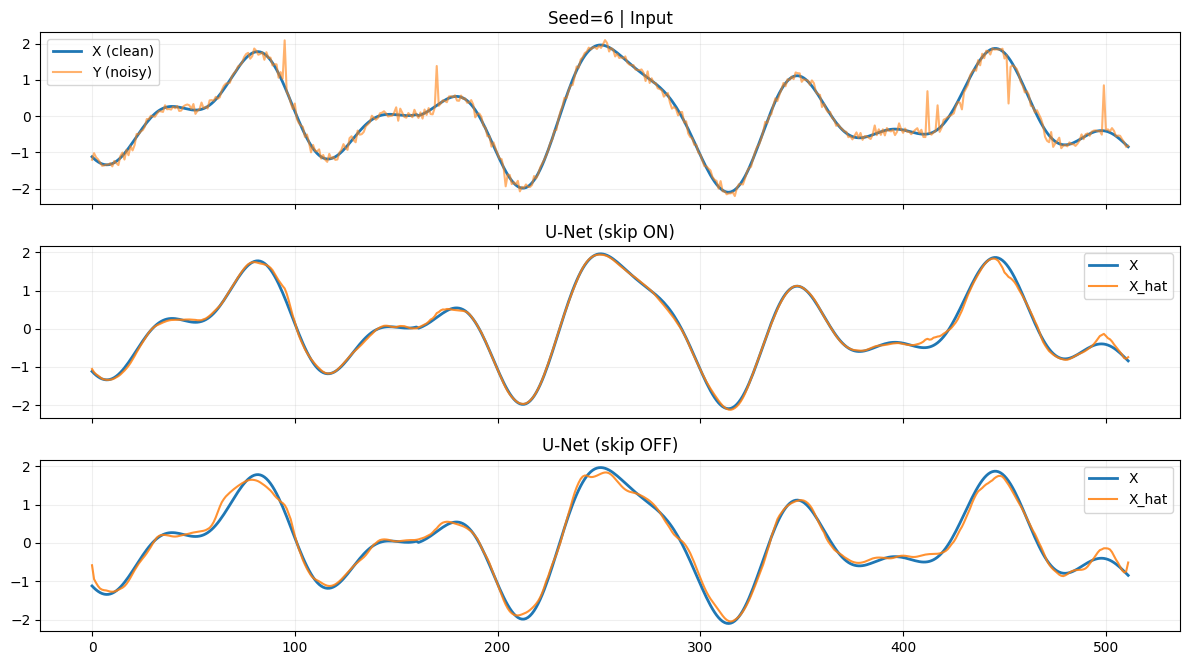

In [27]:
cfg = Signal1DConfig(L=512, use_steps=True, use_spikes=True, do_standardize=True)
seeds_visu = [0, 6]

Y_fix, X_fix = make_fixed_batch(cfg, seeds_visu, device=device)

models = {name: info["model"] for name, info in models_info.items()}
plot_reconstructions(models, Y_fix, X_fix, seeds_visu)

### **Analyse qualitative des reconstructions**

Les reconstructions mettent clairement en évidence l’impact des **connexions de saut** sur la qualité du signal reconstruit.

- **U-Net avec skip connections (ON)**  
  La sortie suit très fidèlement le signal propre, tant sur les composantes lentes que sur les variations locales. Les amplitudes sont bien préservées et les transitions restent nettes, y compris en présence de bruit impulsif. Le débruitage est efficace sans induire de lissage excessif.

- **U-Net sans skip connections (OFF)**  
  La reconstruction demeure globalement correcte mais apparaît plus lissée. Certaines structures fines sont atténuées et l’erreur locale est plus visible, notamment autour des pics et des changements rapides. Le passage par le goulet d’étranglement limite la restitution des détails.

Ces observations sont cohérentes avec les résultats quantitatifs :  
les **skip connections facilitent la propagation de l’information multi-échelle**, permettant au décodeur de réinjecter des détails issus de l’encodeur et d’améliorer la précision locale de la reconstruction.

,name,mse_x,mae_x,r2_x
0,U-Net (skip ON),0.007327,0.051843,0.992673
1,U-Net (skip OFF),0.022468,0.112560,0.977532


,name,mse_lf,mse_hf,nmse_lf,nmse_hf
0,U-Net (skip ON),0.005672,0.001655,0.005799,0.075338
1,U-Net (skip OFF),0.018677,0.003790,0.019097,0.172500


,name,mse_y,copy_ratio_mse,snr_gain_db
0,U-Net (skip ON),0.037002,5.049802,7.992846
1,U-Net (skip OFF),0.052512,2.337246,3.126721


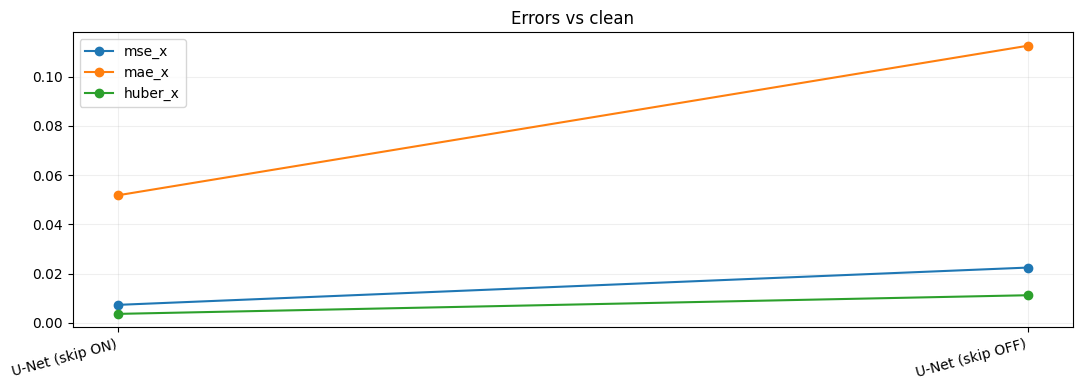

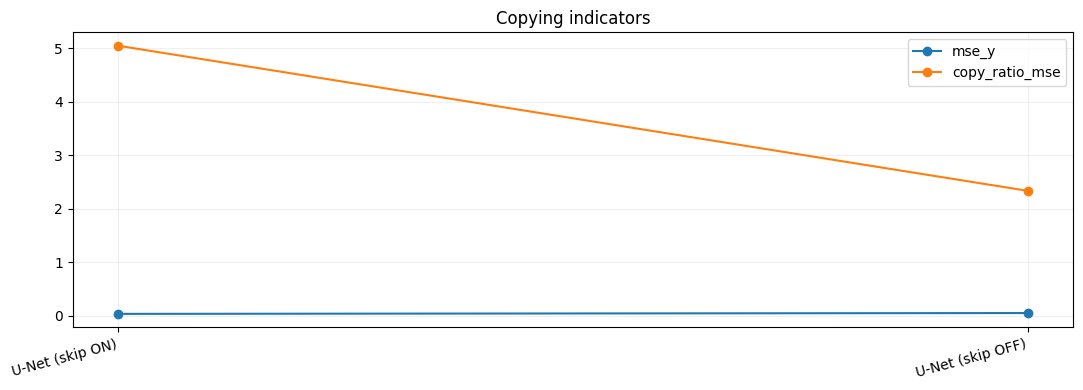

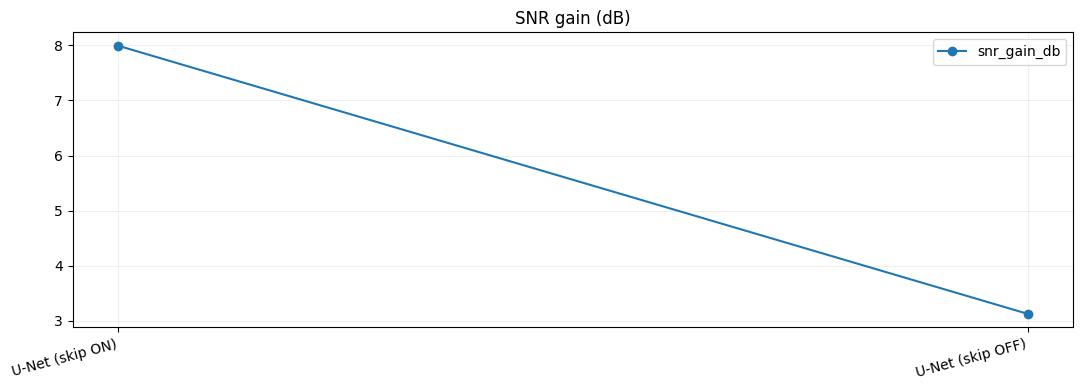

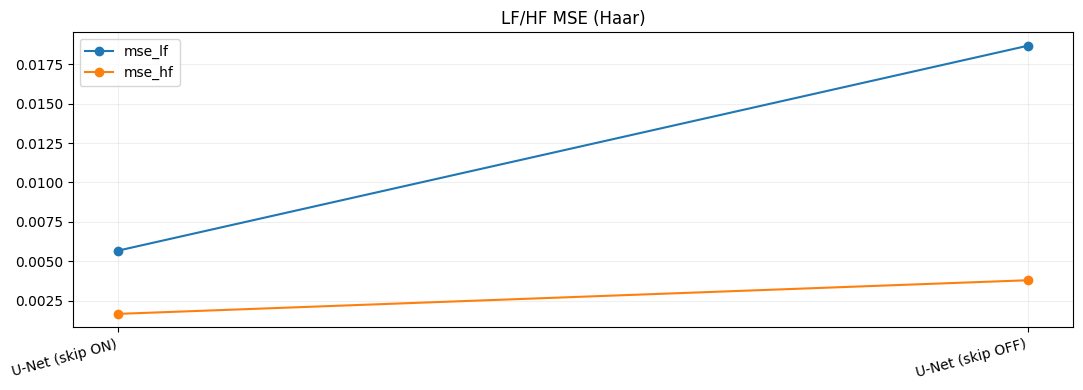

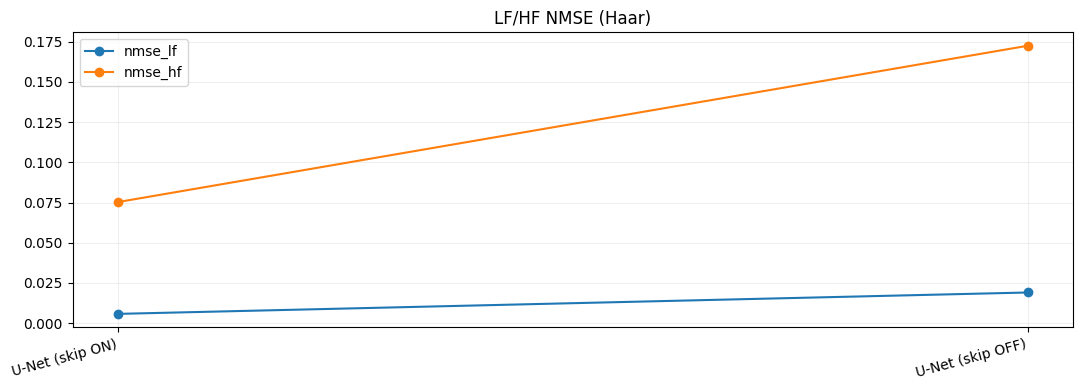

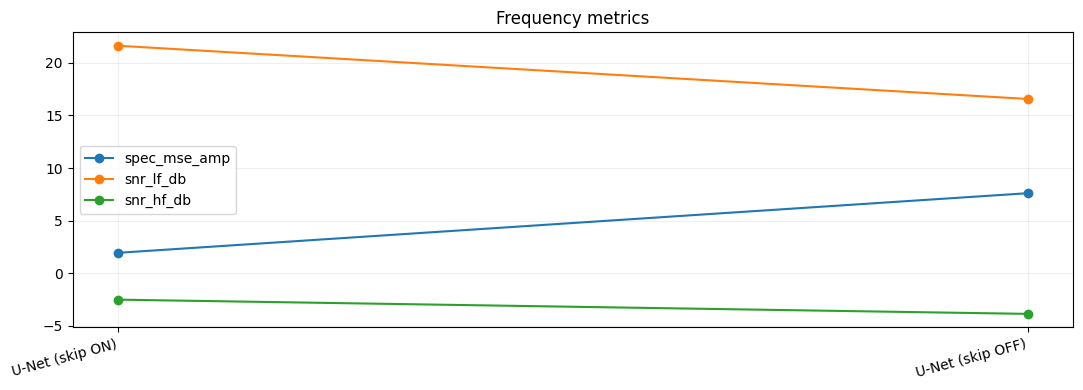

In [28]:
df_metrics = eval_models_table(
    models=models,
    Y=Y_fix,
    X=X_fix,
    lf_levels=3,
    huber_delta=1.0,
    f_split=0.15,
)

#  Tableau principal 
df_global = (
    df_metrics[["name", "mse_x", "mae_x", "r2_x"]]
    .sort_values("mse_x")
    .reset_index(drop=True)
)

order = df_global["name"].tolist()

# Tableau LF/HF (Haar)
df_lf_hf = (
    df_metrics[["name", "mse_lf", "mse_hf", "nmse_lf", "nmse_hf"]]
    .set_index("name")
    .loc[order]
    .reset_index()
)

# Tableau bruit / copie
df_noise = (
    df_metrics[["name", "mse_y", "copy_ratio_mse", "snr_gain_db"]]
    .set_index("name")
    .loc[order]
    .reset_index()
)
display(df_global)
display(df_lf_hf)
display(df_noise)
plot_metric_lines(df_metrics, ["mse_x", "mae_x", "huber_x"], title="Errors vs clean")
plot_metric_lines(df_noise, ["mse_y", "copy_ratio_mse"], title="Copying indicators")
plot_metric_lines(df_noise, ["snr_gain_db"], title="SNR gain (dB)")
plot_metric_lines(df_lf_hf, ["mse_lf", "mse_hf"], title="LF/HF MSE (Haar)")
plot_metric_lines(df_lf_hf, ["nmse_lf", "nmse_hf"], title="LF/HF NMSE (Haar)")
plot_metric_lines(df_metrics, ["spec_mse_amp", "snr_lf_db", "snr_hf_db"], title="Frequency metrics")

### **Analyse quantitative : impact des skip connections**

Les résultats quantitatifs confirment clairement le rôle central des **connexions de saut** dans le U-Net 1D.

Sur les métriques globales, le modèle **U-Net (skip ON)** surpasse systématiquement la version **skip OFF**. On observe une diminution marquée des erreurs de reconstruction ($\mathrm{MSE}_x$, $\mathrm{MAE}_x$) ainsi qu’un coefficient de détermination plus élevé ($R^2 \approx 0.993$ contre $0.978$), indiquant une meilleure fidélité globale au signal propre.

L’analyse fréquentielle renforce ce constat. Les erreurs en basses et hautes fréquences ($\mathrm{MSE}_{\mathrm{LF}}$, $\mathrm{MSE}_{\mathrm{HF}}$) sont toutes deux plus faibles lorsque les skip connections sont activées. Les versions normalisées ($\mathrm{NMSE}_{\mathrm{LF}}$, $\mathrm{NMSE}_{\mathrm{HF}}$) montrent que cette amélioration ne résulte pas uniquement d’un effet d’échelle, mais d’une reconstruction plus équilibrée sur l’ensemble du spectre.

Les indicateurs liés au bruit vont dans le même sens. Le gain de SNR est nettement plus élevé pour **skip ON** (environ +8 dB contre +3 dB), traduisant une suppression du bruit plus efficace. Par ailleurs, le ratio de copie par rapport à l’entrée bruitée reste élevé, ce qui suggère que l’amélioration provient d’une reconstruction plus précise plutôt que d’un simple lissage.

Enfin, les métriques fréquentielles globales (erreur spectrale et SNR par bande) montrent que la suppression des skip connections dégrade la cohérence spectrale du signal reconstruit, en particulier dans les hautes fréquences.

En résumé, les skip connections améliorent simultanément la stabilité de l’optimisation, la qualité globale de la reconstruction et la préservation des différentes échelles fréquentielles du signal.

### **Conclusion de l’expérimentation B**

Cette expérimentation met en évidence l’importance des **connexions de saut** dans l’architecture U-Net 1D. À configuration et données identiques, leur suppression entraîne une dégradation nette de la convergence et des performances finales.

Les modèles avec skip connections convergent plus rapidement, atteignent une perte de validation plus faible et produisent des reconstructions plus fidèles au signal propre. L’analyse fréquentielle montre également une meilleure préservation des basses et hautes fréquences, traduisant un transfert d’information multi-échelle plus efficace entre l’encodeur et le décodeur.

Ces observations confirment le rôle central des skip connections dans les architectures U-Net, en cohérence directe avec les conclusions du papier de référence qui motivent leur utilisation.

## Annexe

#### Introduction à l'analyse multi-résolution et justification des résultats

Etant donnée le cadre que fourni l'approximation multirésolution pour l'analyse des UNet, nous allons faire une introduction de cette théorie. Trois objectifs nous intéressent en particulier :

1. Introduire les termes pour donner un cadre suffisament formel
2. Etablir l'équivalence de caractérisation entre MRA, base d'ondelette orthogonale, et filtre mirroir conjugué
3. Introduire l'algorithme de transformée en ondelettes rapide

La présentation faite ici se base sur le livre [A Wavelet Tour of Signal Processing](https://doi.org/10.1016/B978-0-12-374370-1.X0001-8) de Mallat (particulièrement le chapitre 7, et en moindre mesure les chapitres 4 et 5). Bien que ce ne soit pas notre sujet mentionnons pour la complétion que ce travail de Mallat accorde aussi beaucoup de soin à des caractérisations et contraintes permettant la construction aisée de filtres et bases d'ondelettes.

---

**L'approximation multirésolution** constitue l'approximation des fonctions de $L^2(\R)$ à diverses résolutions en les projetants orthogonalement sur une suite de sous espaces emboités $(V_j)$ (dits d'approximation à résolution $j$). L'approximation d'une fonction $f \in L^2(\R)$ à résolution $2^j$ est spécifiée par une suite d'échantillons fournissant une moyenne locale de $f$ sur des voisinages de taille $2^{-j}$.


L'interêt est très appliqué : adapter la résolution d'une fonction permet de ne tenir compte que des détails nécessaires à une certaine tache.

On peut montrer que l'analyse multirésolution est entièrement caractérisée par un filtre dicret (i.e. une suite servant de noyau à une convolution discrète) qui détermine par ailleurs la perte d'information entre résolutions.


On va commencer par définir un peu rigoureusement la notion d'approximation multirésolution, puis faire la construction des bases d'ondelettes orthogonales.

Une **analyse multi-résolution (MRA)** de $L^2(\R)$ est la donnée d'une suite de sous espaces emboités $(V_j)$, $j \in \Z$, vérifiants :

1. $V_j \subset V_{j+1}$
2. $f \in V_j  \iff f(2 \cdot) \in V_{j+1}$
3. $f \in V_0  \iff f(\cdot - k) \in V_0 ,\ \forall k \in \Z$
4. $\underset{j \in \Z}{\bigcap} V_j = \set{0}$ et $\underset{j \in \Z}{\bigcup} V_j$ dense dans $L^2(\R)$
5. Il existe une $\phi \in V_0$ telle que $\set{\phi_k := \phi( \cdot - k) }_{k \in \Z}$ est une base orthonormale de $V_0$. $\phi$ est appelée **fonction échelle** (ou éventuellement ondelette père).

$\phi$ peut s'interpréter comme un pixel dans la résolution donnée.

L'hypothèse 4. garantie que tendre vers $-\infty$ mène à perdre tous détail, tandis que tendre vers $+\infty$ approche la fonction originale $f$ : $\underset{j \to \infty}{\lim} {\vert\vert f - P_{V_j} f \vert\vert} = 0$. _Il est par ailleurs possible de lier la vitesse de convergence à la régularité lipshitz de $f$._

Remarquons tout de suite que le sous espace $V_j$ est engendré par une base orthonormale consituée de $\set{\phi_{j, k} := 2^{j / 2}\phi(2^j \cdot - k) }_{k \in \Z}$.

En conséquence l'approximation d'une fonction $f \in L^2(\R)$ à résolution $j$, qui est définie comme la projection orthogonale de $f$ sur $V_j$, s'obtient par expansion dans cette base : en notant $a_j[k] = \langle f, \phi_{j, k} \rangle$ on a $P_{V_j} f = \underset{k}{\sum} a_j[k] \phi_{j, k}$.

###### Exemple : Approximation multirésolution constante par morceau

Un exemple simple et intuitif d'approximation multirésolution est composée par les fonctions constantes par morceaux. L'espace d'approximation $V_j$ est l'ensemble des fonctions constante sur les intervalles $[\frac{k}{2^j}, \frac{k+1}{2^j})$, l'approximation de $f \in L^2(\R)$ à résolution $j$ est la projection sur ces fonctions constantes, et la fonction d'échelle est la fenêtre $\mathbb{1}_{[0, 1)}$.

#### Caractérisation de l'approximation multirésolution par filtre mirroir conjugué

Une approximation multirésolution est entièrement caractérisée par la fonction d'échelle $\phi$, qui génère une base orthogonale de chaque espace $V_j$. 

_Il est possible d'étudier les propriétée de $\phi$ qui garantissent que les espaces $(V_j)$ satisfont toutes les conditions d'une approximation multi-résolution, c'est utile entre autres pour la construction de tels approximations._ 

Il est également possible de prouver que toute fonction échelle est caractérisée par un filtre discret (appelé **filtre miroir conjugué**), c'est ce qui nous intéresse ici.

###### Equation de dilatation

En effet, il existe une suite $h[k]$ telle que 

$$\phi(x) = \sqrt{2} \underset{k \in \Z}{\sum} h[k] \phi(2 x - k)$$

avec $h[k] = \langle \phi, \sqrt(2) \phi(2 \cdot - k) \rangle$

_Schéma de preuve : Il suffit de voir que $\phi \in V_0 \subset V_1$ et que $\set{\phi_{1, k}}$ est base de $V_1$._

Cette suite $h[k]$ s'interprète donc comme un filtre discret.

La caractérisation d'une fonction échelle par le filtre $h$ est dûe à une théorème de Mallat et Meyer dont la preuve un peu longue peut être trouvée page 310.

**Théorème** : Considère $\phi \in L^2(\R)$ une fonction échelle intégrable. La série de Fourier de $h[k] = \langle \phi, \sqrt{2} \phi(2 \cdot - k) \rangle$ satisfait 

$$
\begin{align*}
\forall \omega \in \R \quad \vert \hat{h}(\omega) \vert^2 + \vert \hat{h}(\omega + \pi) \vert^2 &= 2 \tag{1} \\
\hat{h}(0) &= \sqrt{2} \tag{2}
\end{align*}$$

Réciproquement, si $\hat{h}$ est $2\pi$-périodique et continuement différentiable sur un voisinage de $0$, si elle satisfait les deux points précédents, et si $\underset{\omega \in [-\pi / 2, \pi / 2]}{\inf} \vert \hat{h} \vert > 0$ alors 

$$\hat{\phi}(\omega) = \prod_{j \ge 1} \frac{\hat{h}(2^{-j}\omega)}{\sqrt{2}}$$

est la transformée de Fourier d'une fonction d'échelle $\phi \in L^2(\R)$.

En particulier, les filtres $h$ qui respectent la condition $(1)$ sont appelées **filtres miroirs conjugués**.


#### Lien avec les bases d'ondelette orthogonales

Le role des ondelette est de porter les détails nécessaire à l'augmentation de résolution d'un approximation de $f$. 

Plus formellement, on sait que $V_j \subset V_{j+1}$, notons $W_j$ le supplémentaire de $V_j$ dans $V_{j+1}$ : $V_{j+1} = V_j \oplus W_j$. Puis décomposons la projection de $f$ sur $V_{j+1}$ : $P_{V_{j+1}} f = P_{V_j} f + P_{W_j} f$. 

On interprète $P_{W_j} f$ comme les détails de $f$ qui apparaissent à échelle $j+1$ mais disparaissent à échelle $j$.

On peut prouver qu'il est possible de construire une base orthonormale de $W_j$ en dilatant et translatant une ondelette $\psi$ caractérisée par le filtre miroir conjugué. La preuve peut être trouvée page 320.

Considèrons la fonction d'échelle \phi et $h$ le filtre mirroir conjugué associé. Notons \psi la fonction dont la transformée de Fourier s'écrit

$$\hat{\psi}(\omega) = \frac{1}{\sqrt{2}} \hat{g}(\frac{w}{2}) \hat{\phi}(\frac{w}{2})$$

où 

$$\hat{g} = e^{-i\omega} \hat{h}^*(\omega + \pi)$$

En notant $\psi_{j, k} = \frac{1}{\sqrt{2^j}} \psi(\frac{t - 2^jk}{2^k})$ pour toute échelle $j$ $\set{\psi_{j, k}}_{k \in \Z}$ est une base orthonormale de $W_j$ et $\set{\psi_{j, k}}_{j, k \in \Z}$ est une base orthonormale de $L^2(\R)$.

Par ailleurs on peut lier $g$ à $h$ par la relation $g[k] = (-1)^{1 - k}h[1 - k]$.

Ce théorème nous dit qu'il est possible de construire une base orthonormale d'ondelettes orthonormales à partir d'un filtre miroir conjugué. On pourrait se demander si réciproquement toute base d'ondelettes orthogonale est associée à une MRA et un filtre miroir conjugué. Si l'on impose que $\psi$ ait support compact, Lemarié a en effet prouvé que $\psi$ correspond à une MRA. [[Les ondelettes en 1989, Lecture Notes in Mathematics 1438, P.G.Lemarié ed.]](https://math.maths.univ-evry.fr/lemarie/publi/mypp.html)

#### Support compact

_WIP_

#### MRA multidimensionelle

_WIP_

#### Transformée en ondelette rapide

Cet algorithme de banc de filtres calcul les coefficients d'ondelettes d'une fonction échantillonée à résolution finie $j$.

L'algorithme de transformée en ondelettes rapide décompose récursivement chaque approximation $P_{V_{j + 1}} f$ en une approximation plus grossière $P_{V_j} f$ et les coefficients d'ondelettes portés par $P_{W_{j + 1}} f$. 

Dans l'autre direction la transformée en ondelettes inverse rapide reconstruit chaque $P_{V_{j + 1}} f$ à partir de $P_{V_j} f$ et $P_{W_{j + 1}} f$. 

On va noter $a_j[k] = \langle f, \phi_{j, k} \rangle$ et $d_j[k] = \langle f, \psi_{j, k} \rangle$ les coefficients des projections de $f$.

On va montrer que ces coefficient sont calculable par une récursion de convolutions discrètes et de sous-échantillonages, c'est à dire que


$$
\begin{align*}
a_j[k] &= \underset{k' \in \Z}{\sum} h[k' - 2k] a_{j+1}[k] \\
d_j[k] &= \underset{k' \in \Z}{\sum} g[k' - 2k] d_{j+1}[k]
\end{align*}
$$

et 

$$
a_{j+1}[k] = 
\underset{k' \in \Z}{\sum} h[k - 2k'] a_j[k']
+ \underset{k' \in \Z}{\sum} g[k - 2k'] d_j[k']
$$


_Schéma de preuve : décomposer $\phi_{j, k}$ dans la base, écrire le produit scalaire comme intégral, changer de variable, repasser en porduit scalaire pour identifier._

Ce résultat donne assez directement l'algorithme récursif de transformée en ondelette.


![By User:Johnteslade, Public Domain, https://commons.wikimedia.org/w/index.php?curid=225721](https://upload.wikimedia.org/wikipedia/commons/2/22/Wavelets_-_Filter_Bank.png)

_Schéma de l'étape de décomposition : récursivement, on applique les filtres $h$ et $g$, puis on sous-échantillone par 2._



## Références

- [A Unified Framework for U-Net Design and Analysis, C. Williams, F. Falck](https://arxiv.org/pdf/2305.19638)
- [U-Net: Convolutional Networks for Biomedical Image Segmentation, O. Ronneberger, P. Fischer, T. Brox](https://arxiv.org/pdf/1505.04597)
- [A Wavelet Tour of Signal Processing, Mallat](https://doi.org/10.1016/B978-0-12-374370-1.X0001-8)
- [Neural Ordinary Differential Equations, R. T. Q. Chen, Y. Rubanova, J. Bettencourt](https://arxiv.org/pdf/1806.07366)
- [Estimation Non Paramétrique I. Castillo](https://perso.lpsm.paris/~castillo/np/np.html)
- [Introduction to Machine Learning, M. Sangnier](https://perso.lpsm.paris/~msangnier/files/mlM2/notes_student.pdf)